# Dataset Class

In [12]:
import os
import numpy as np
import pandas as pd

import cv2
import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

class FacePointsDataset(Dataset):

    def __init__(self, images_dir, keypoints_csv=None, target_size=100, is_train=True, device=None):
        """
        :param images_dir: string, root directory for images
        :param keypoints_csv: string, keypoints csv path
        :param target_size: int, size of a square trainable image
        :param transform: callable | optional, transforms applied to columns

        :return: dataset
        """
        self.images_dir = images_dir
        self.keypoints_csv = pd.read_csv(keypoints_csv) if keypoints_csv else None
        self.target_size = target_size
        self.is_train = is_train
        self.device = device

        if self.keypoints_csv is not None:
            self.image_files = self.keypoints_csv.iloc[:, 0].tolist()
        else:
            self.image_files = [file for file in os.listdir(images_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            self.image_files.sort()
            assert len(self.image_files) > 0, f"No images found in {images_dir}"

        self.train_transform = A.Compose([
            A.HorizontalFlip(.5),
            A.CoarseDropout(num_holes_range=(4, 6), hole_width_range=(0.05, 0.2), hole_height_range=(0.05, 0.2), p=.5),
            A.ShiftScaleRotate(shift_limit=.05, scale_limit=.1, rotate_limit=75, p=.7),
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 7), p=0.5),
                A.MotionBlur(blur_limit=(3, 7), p=0.5),
            ], p=0.5),
            A.GaussNoise(std_range=(.001, .02), p=0.5),
            A.ColorJitter(brightness=.25, contrast=.25, saturation=.3, hue=.03, p=.8),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

        self.test_transform = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


    def __len__(self):
        return len(self.image_files)
    

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.images_dir, self.image_files[idx])
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image not found: {img_name}")
        
        image = cv2.imread(img_name)
        if image is None:
            raise ValueError(f"Failed to load image: {img_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        keypoints = self.keypoints_csv.iloc[idx, 1:].values.astype(float).reshape(-1, 2) if self.keypoints_csv is not None else None
        image, keypoints = self.smart_resize_with_padding(
            image, keypoints, self.target_size
        )
        
        if keypoints is not None:
            keypoints_list = [(float(keypoint[0]), float(keypoint[1])) for keypoint in keypoints]
            
            transform = self.train_transform if self.is_train else self.test_transform
            transformed = transform(image=image, keypoints=keypoints_list)
            image = transformed['image']
            keypoints = np.array(transformed['keypoints']) / self.target_size

            keypoints_tensor = torch.tensor(keypoints.flatten(), dtype=torch.float32)
            if self.device:
                keypoints_tensor = keypoints_tensor.to(self.device)
            return image, keypoints_tensor
        
        else:
            transform = self.train_transform if self.is_train else self.test_transform
            image = transform(image=image, keypoints=[])['image']
            return image
    
    
    @staticmethod
    def smart_resize_with_padding(image, keypoints, target_size):
        h, w = image.shape[:2]
        scale = min(target_size/h, target_size/w)
        new_w, new_h = int(w*scale), int(h*scale)
        resized_image = cv2.resize(image, (new_w, new_h))

        padded_image = np.zeros((target_size, target_size, 3), dtype=np.uint8)
        start_x = (target_size - new_w) // 2
        start_y = (target_size - new_h) // 2

        padded_image[start_y : start_y+new_h, start_x : start_x+new_w] = resized_image

        if keypoints is not None:
            scaled_keypoints = keypoints * scale
            scaled_keypoints += np.array((start_x, start_y))
            return padded_image, scaled_keypoints

        return padded_image, None

# Loading Datasets

In [13]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 32

train_dataset = FacePointsDataset('./tests/00_test_img_input/train/images', './tests/00_test_img_input/train/gt.csv', device=device)
val_dataset = FacePointsDataset('./tests/00_test_img_input/train/images', './tests/00_test_img_input/train/gt.csv', is_train=False, device=device)
test_dataset = FacePointsDataset('./tests/00_test_img_input/test/images', is_train=False, device=device)

train_size = int(.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, _ = torch.utils.data.random_split(train_dataset, (train_size, val_size))
_, val_subset = torch.utils.data.random_split(val_dataset, (train_size, val_size))

train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

c:\Users\fazulzyanov.rr\AppData\Local\Python\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
c:\Users\fazulzyanov.rr\AppData\Local\Python\Lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for keypoints, but no transform to process it.
  self._set_keys()
c:\Users\fazulzyanov.rr\AppData\Local\Python\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
c:\Users\fazulzyanov.rr\AppData\Local\Python\Lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for keypoints, but no transform to process it.
  self._set_keys()


# Augmentations Visualization

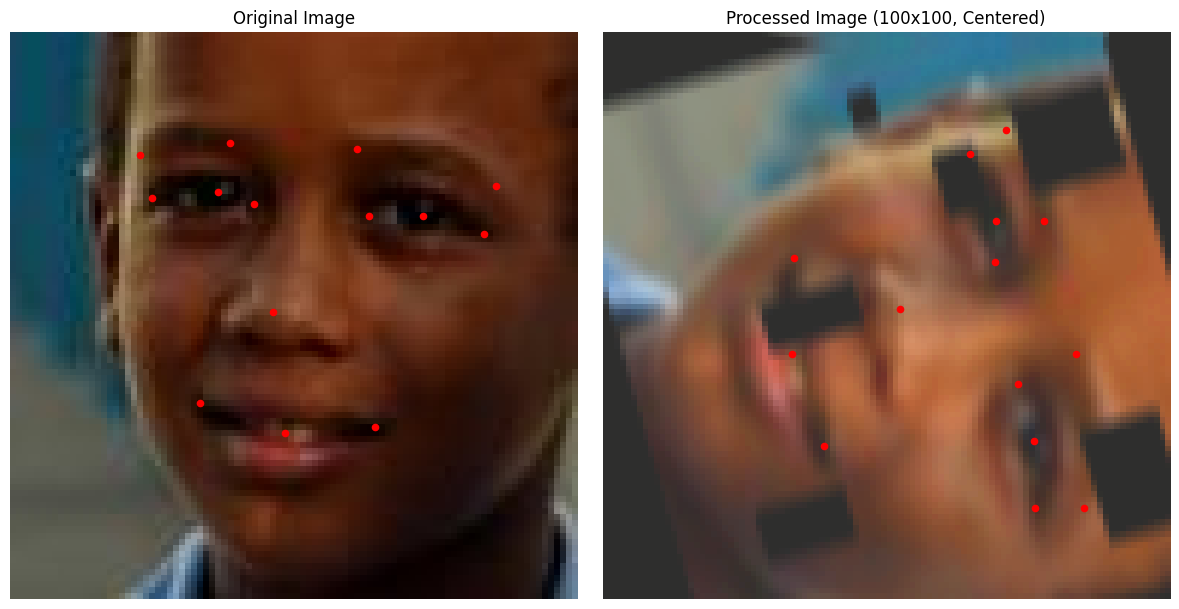

In [14]:
import matplotlib.pyplot as plt
import cv2

def visualize_preprocessing(original_img_path, keypoints, dataset_entry=None):
    """
    Preprocessing visualization
    """
    original_img = cv2.imread(original_img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    if dataset_entry is not None:
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    else:
        _, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
    
    ax1.imshow(original_img)
    ax1.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=20)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    if dataset_entry is not None:
        processed_img, processed_keypoints = dataset_entry
        
        processed_img = processed_img.permute(1, 2, 0)  # CHW to HWC
        processed_img = processed_img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]) #denormalize
        processed_img = torch.clamp(processed_img, 0, 1)
        
        processed_keypoints = torch.Tensor.cpu(processed_keypoints)
        processed_keypoints = processed_keypoints.reshape(-1, 2) * 100

        ax2.imshow(processed_img)
        ax2.scatter(processed_keypoints[:, 0], processed_keypoints[:, 1], c='red', s=20)
        ax2.set_title('Processed Image (100x100, Centered)')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_preprocessing('./tests/00_test_img_input/train/images/00001.jpg',
                        pd.read_csv('./tests/00_test_img_input/train/gt.csv').iloc[1, 1:].values.reshape(-1, 2),
                        train_dataset[1])

# Metrics Visualizer

In [15]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_mses, val_mses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # График loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # График accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_mses, 'b-', label='Train MSE')
    plt.plot(epochs, val_mses, 'r-', label='Validation MSE')
    plt.title('MSE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Model

In [52]:
import torch
from torch import nn, optim
from tqdm.notebook import tqdm

class WingLoss(nn.Module):
    def __init__(self, w=10, epsilon=2):
        super(WingLoss, self).__init__()
        self.w = w
        self.epsilon = epsilon
        self.C = self.w - self.w * np.log(1 + self.w / self.epsilon)

    def forward(self, predictions, targets):
        diff = torch.abs(predictions - targets)
        
        loss = torch.where(
            diff < self.w,
            self.w * torch.log(1 + diff / self.epsilon),
            diff - self.C
        )
        
        return torch.mean(loss)


class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.GELU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class FacePointsCNN(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.gelu = nn.GELU()
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout1 = nn.Dropout2d(.0)
        self.dropout2 = nn.Dropout2d(.0)
        self.dropout3 = nn.Dropout2d(.0)
        self.dropout4 = nn.Dropout(.1)
        self.dropout5 = nn.Dropout(.1)

        self.bnorm1 = nn.BatchNorm2d(64)
        self.bnorm2 = nn.BatchNorm2d(128)
        self.bnorm3 = nn.BatchNorm2d(256)
        self.bnorm4 = nn.BatchNorm2d(512)
        self.bnorm5 = nn.BatchNorm2d(1024)
        self.fc_bnorm = nn.LazyBatchNorm1d()

        self.seb1 = SEBlock(64)
        self.seb2 = SEBlock(128)
        self.seb3 = SEBlock(256)
        self.seb4 = SEBlock(512)
        self.seb5 = SEBlock(1024)

        self.fc1 = nn.Linear(256*12*12, 64)
        self.fc2 = nn.Linear(64, 28)

    def forward(self, x):

        x = self.pool(self.seb1(self.gelu(self.bnorm1(self.conv1(x)))))                    #64, 48, 48
        x = self.dropout1(self.pool(self.seb2(self.gelu(self.bnorm2(self.conv2(x))))))     #128, 24, 24
        x = self.dropout2(self.pool(self.seb3(self.gelu(self.bnorm3(self.conv3(x))))))     #256, 12, 12
        # x = self.dropout3(self.pool(self.seb4(self.gelu(self.bnorm4(self.conv4(x))))))     #512, 6, 6
        # x = self.dropout3(self.pool(self.seb5(self.gelu(self.bnorm5(self.conv5(x))))))     #1024, 3, 3
        x = torch.flatten(x, 1)                                                            #1024*3*3
        x = self.dropout4(self.gelu(self.fc1(x)))                                          #256
        x = self.fc2(x)                                                                    #28
        return x
    
model = FacePointsCNN()
model.to(device)

FacePointsCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gelu): GELU(approximate='none')
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout1): Dropout2d(p=0.0, inplace=False)
  (dropout2): Dropout2d(p=0.0, inplace=False)
  (dropout3): Dropout2d(p=0.0, inplace=False)
  (dropout4): Dropout(p=0.1, inplace=False)
  (dropout5): Dropout(p=0.1, inplace=False)
  (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnor

# Training

Epoch:   0%|          | 0/600 [00:00<?, ?it/s]

Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1 - train loss: 0.9786 - train rmse: 0.2806 - val loss: 0.5880 - val rmse: 0.1718
Validation MSE improved (inf --> 0.0295). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 2 - train loss: 0.7672 - train rmse: 0.2150 - val loss: 0.4994 - val rmse: 0.1479
Validation MSE improved (0.0295 --> 0.0219). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 3 - train loss: 0.7068 - train rmse: 0.1950 - val loss: 0.5139 - val rmse: 0.1460
Validation MSE improved (0.0219 --> 0.0213). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 4 - train loss: 0.6499 - train rmse: 0.1798 - val loss: 0.4698 - val rmse: 0.1349
Validation MSE improved (0.0213 --> 0.0182). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 5 - train loss: 0.6000 - train rmse: 0.1670 - val loss: 0.4786 - val rmse: 0.1396
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 6 - train loss: 0.5632 - train rmse: 0.1576 - val loss: 0.4561 - val rmse: 0.1328
Validation MSE improved (0.0182 --> 0.0176). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 7 - train loss: 0.5422 - train rmse: 0.1534 - val loss: 0.4790 - val rmse: 0.1505
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 8 - train loss: 0.5317 - train rmse: 0.1519 - val loss: 0.4307 - val rmse: 0.1350
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 9 - train loss: 0.5256 - train rmse: 0.1508 - val loss: 0.4708 - val rmse: 0.1459
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 - train loss: 0.5177 - train rmse: 0.1499 - val loss: 0.3599 - val rmse: 0.1143
Validation MSE improved (0.0176 --> 0.0131). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 11 - train loss: 0.5117 - train rmse: 0.1489 - val loss: 0.3525 - val rmse: 0.1153
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 12 - train loss: 0.5061 - train rmse: 0.1481 - val loss: 0.4983 - val rmse: 0.1596
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 13 - train loss: 0.5032 - train rmse: 0.1480 - val loss: 0.3819 - val rmse: 0.1266
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 14 - train loss: 0.4987 - train rmse: 0.1472 - val loss: 0.4041 - val rmse: 0.1329
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 15 - train loss: 0.4974 - train rmse: 0.1468 - val loss: 0.3568 - val rmse: 0.1163
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 16 - train loss: 0.4895 - train rmse: 0.1452 - val loss: 0.3354 - val rmse: 0.1088
Validation MSE improved (0.0131 --> 0.0118). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 17 - train loss: 0.4836 - train rmse: 0.1448 - val loss: 0.3193 - val rmse: 0.1026
Validation MSE improved (0.0118 --> 0.0105). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 18 - train loss: 0.4852 - train rmse: 0.1445 - val loss: 0.3547 - val rmse: 0.1203
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 19 - train loss: 0.4824 - train rmse: 0.1445 - val loss: 0.3912 - val rmse: 0.1322
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 20 - train loss: 0.4811 - train rmse: 0.1436 - val loss: 0.3184 - val rmse: 0.1104
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 21 - train loss: 0.4798 - train rmse: 0.1434 - val loss: 0.4146 - val rmse: 0.1378
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 22 - train loss: 0.4797 - train rmse: 0.1435 - val loss: 0.3599 - val rmse: 0.1243
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 23 - train loss: 0.4747 - train rmse: 0.1415 - val loss: 0.3652 - val rmse: 0.1254
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 24 - train loss: 0.4724 - train rmse: 0.1418 - val loss: 0.4325 - val rmse: 0.1421
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 25 - train loss: 0.4683 - train rmse: 0.1411 - val loss: 0.3522 - val rmse: 0.1213
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 26 - train loss: 0.4688 - train rmse: 0.1422 - val loss: 0.3742 - val rmse: 0.1255
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 27 - train loss: 0.4631 - train rmse: 0.1407 - val loss: 0.3749 - val rmse: 0.1266
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 28 - train loss: 0.4659 - train rmse: 0.1409 - val loss: 0.4201 - val rmse: 0.1452
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 29 - train loss: 0.4649 - train rmse: 0.1406 - val loss: 0.4072 - val rmse: 0.1394
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 30 - train loss: 0.4616 - train rmse: 0.1414 - val loss: 0.4030 - val rmse: 0.1353
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 31 - train loss: 0.4605 - train rmse: 0.1403 - val loss: 0.2605 - val rmse: 0.0912
Validation MSE improved (0.0105 --> 0.0083). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 32 - train loss: 0.4588 - train rmse: 0.1401 - val loss: 0.3595 - val rmse: 0.1253
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 33 - train loss: 0.4600 - train rmse: 0.1410 - val loss: 0.3657 - val rmse: 0.1271
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 34 - train loss: 0.4541 - train rmse: 0.1395 - val loss: 0.3425 - val rmse: 0.1218
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 35 - train loss: 0.4585 - train rmse: 0.1400 - val loss: 0.3836 - val rmse: 0.1331
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 36 - train loss: 0.4535 - train rmse: 0.1391 - val loss: 0.3401 - val rmse: 0.1193
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 37 - train loss: 0.4525 - train rmse: 0.1395 - val loss: 0.2939 - val rmse: 0.1055
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 38 - train loss: 0.4525 - train rmse: 0.1398 - val loss: 0.3225 - val rmse: 0.1129
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 39 - train loss: 0.4499 - train rmse: 0.1388 - val loss: 0.3919 - val rmse: 0.1346
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 40 - train loss: 0.4515 - train rmse: 0.1389 - val loss: 0.3327 - val rmse: 0.1179
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 41 - train loss: 0.4472 - train rmse: 0.1379 - val loss: 0.2756 - val rmse: 0.0994
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 42 - train loss: 0.4456 - train rmse: 0.1378 - val loss: 0.3810 - val rmse: 0.1314
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 43 - train loss: 0.4504 - train rmse: 0.1387 - val loss: 0.3750 - val rmse: 0.1297
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 44 - train loss: 0.4485 - train rmse: 0.1385 - val loss: 0.2994 - val rmse: 0.1056
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 45 - train loss: 0.4438 - train rmse: 0.1375 - val loss: 0.3881 - val rmse: 0.1362
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 46 - train loss: 0.4452 - train rmse: 0.1378 - val loss: 0.3523 - val rmse: 0.1217
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 47 - train loss: 0.4387 - train rmse: 0.1370 - val loss: 0.3830 - val rmse: 0.1331
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 48 - train loss: 0.4418 - train rmse: 0.1377 - val loss: 0.3595 - val rmse: 0.1262
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 49 - train loss: 0.4423 - train rmse: 0.1370 - val loss: 0.3189 - val rmse: 0.1132
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 50 - train loss: 0.4421 - train rmse: 0.1372 - val loss: 0.4180 - val rmse: 0.1460
Validation MSE did not improve. Counter: 19/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 51 - train loss: 0.4395 - train rmse: 0.1363 - val loss: 0.3990 - val rmse: 0.1425
Validation MSE did not improve. Counter: 20/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 52 - train loss: 0.4408 - train rmse: 0.1374 - val loss: 0.3780 - val rmse: 0.1335
Validation MSE did not improve. Counter: 21/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 53 - train loss: 0.4372 - train rmse: 0.1367 - val loss: 0.3323 - val rmse: 0.1164
Validation MSE did not improve. Counter: 22/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 54 - train loss: 0.4347 - train rmse: 0.1357 - val loss: 0.3241 - val rmse: 0.1145
Validation MSE did not improve. Counter: 23/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 55 - train loss: 0.4412 - train rmse: 0.1365 - val loss: 0.3758 - val rmse: 0.1316
Validation MSE did not improve. Counter: 24/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 56 - train loss: 0.4374 - train rmse: 0.1357 - val loss: 0.3142 - val rmse: 0.1121
Validation MSE did not improve. Counter: 25/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 57 - train loss: 0.4343 - train rmse: 0.1350 - val loss: 0.3532 - val rmse: 0.1212
Validation MSE did not improve. Counter: 26/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 58 - train loss: 0.4363 - train rmse: 0.1355 - val loss: 0.3142 - val rmse: 0.1120
Validation MSE did not improve. Counter: 27/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 59 - train loss: 0.4343 - train rmse: 0.1352 - val loss: 0.3313 - val rmse: 0.1155
Validation MSE did not improve. Counter: 28/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 60 - train loss: 0.4332 - train rmse: 0.1352 - val loss: 0.3445 - val rmse: 0.1221
Validation MSE did not improve. Counter: 29/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 61 - train loss: 0.4336 - train rmse: 0.1349 - val loss: 0.3374 - val rmse: 0.1201
Validation MSE did not improve. Counter: 30/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 62 - train loss: 0.4294 - train rmse: 0.1341 - val loss: 0.3259 - val rmse: 0.1145
Validation MSE did not improve. Counter: 31/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 63 - train loss: 0.4322 - train rmse: 0.1345 - val loss: 0.3309 - val rmse: 0.1169
Validation MSE did not improve. Counter: 32/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 64 - train loss: 0.4351 - train rmse: 0.1353 - val loss: 0.3048 - val rmse: 0.1088
Validation MSE did not improve. Counter: 33/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 65 - train loss: 0.4288 - train rmse: 0.1332 - val loss: 0.3162 - val rmse: 0.1140
Validation MSE did not improve. Counter: 34/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 66 - train loss: 0.4248 - train rmse: 0.1327 - val loss: 0.3470 - val rmse: 0.1235
Validation MSE did not improve. Counter: 35/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 67 - train loss: 0.4278 - train rmse: 0.1335 - val loss: 0.3384 - val rmse: 0.1224
Validation MSE did not improve. Counter: 36/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 68 - train loss: 0.4251 - train rmse: 0.1324 - val loss: 0.3083 - val rmse: 0.1089
Validation MSE did not improve. Counter: 37/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 69 - train loss: 0.4316 - train rmse: 0.1337 - val loss: 0.3474 - val rmse: 0.1190
Validation MSE did not improve. Counter: 38/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 70 - train loss: 0.4268 - train rmse: 0.1321 - val loss: 0.2831 - val rmse: 0.1016
Validation MSE did not improve. Counter: 39/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 71 - train loss: 0.4249 - train rmse: 0.1327 - val loss: 0.2554 - val rmse: 0.0902
Validation MSE improved (0.0083 --> 0.0081). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 72 - train loss: 0.4203 - train rmse: 0.1311 - val loss: 0.3072 - val rmse: 0.1107
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 73 - train loss: 0.4219 - train rmse: 0.1316 - val loss: 0.3011 - val rmse: 0.1080
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 74 - train loss: 0.4245 - train rmse: 0.1320 - val loss: 0.3415 - val rmse: 0.1216
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 75 - train loss: 0.4261 - train rmse: 0.1329 - val loss: 0.2962 - val rmse: 0.1064
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 76 - train loss: 0.4200 - train rmse: 0.1314 - val loss: 0.3336 - val rmse: 0.1145
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 77 - train loss: 0.4199 - train rmse: 0.1311 - val loss: 0.2894 - val rmse: 0.1042
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 78 - train loss: 0.4196 - train rmse: 0.1312 - val loss: 0.3262 - val rmse: 0.1153
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 79 - train loss: 0.4184 - train rmse: 0.1303 - val loss: 0.2917 - val rmse: 0.1051
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 80 - train loss: 0.4123 - train rmse: 0.1292 - val loss: 0.3436 - val rmse: 0.1202
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 81 - train loss: 0.4193 - train rmse: 0.1307 - val loss: 0.3514 - val rmse: 0.1241
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 82 - train loss: 0.4180 - train rmse: 0.1309 - val loss: 0.2823 - val rmse: 0.1000
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 83 - train loss: 0.4173 - train rmse: 0.1304 - val loss: 0.3291 - val rmse: 0.1160
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 84 - train loss: 0.4162 - train rmse: 0.1295 - val loss: 0.2814 - val rmse: 0.0988
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 85 - train loss: 0.4098 - train rmse: 0.1283 - val loss: 0.2923 - val rmse: 0.1029
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 86 - train loss: 0.4113 - train rmse: 0.1291 - val loss: 0.3261 - val rmse: 0.1161
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 87 - train loss: 0.4141 - train rmse: 0.1290 - val loss: 0.3245 - val rmse: 0.1140
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 88 - train loss: 0.4110 - train rmse: 0.1285 - val loss: 0.2769 - val rmse: 0.0972
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 89 - train loss: 0.4107 - train rmse: 0.1283 - val loss: 0.3224 - val rmse: 0.1122
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 90 - train loss: 0.4069 - train rmse: 0.1273 - val loss: 0.2801 - val rmse: 0.0990
Validation MSE did not improve. Counter: 19/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 91 - train loss: 0.4133 - train rmse: 0.1288 - val loss: 0.2853 - val rmse: 0.1030
Validation MSE did not improve. Counter: 20/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 92 - train loss: 0.4096 - train rmse: 0.1280 - val loss: 0.2531 - val rmse: 0.0886
Validation MSE improved (0.0081 --> 0.0079). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 93 - train loss: 0.4075 - train rmse: 0.1275 - val loss: 0.2957 - val rmse: 0.1053
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 94 - train loss: 0.4078 - train rmse: 0.1272 - val loss: 0.2877 - val rmse: 0.1014
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 95 - train loss: 0.4111 - train rmse: 0.1279 - val loss: 0.2788 - val rmse: 0.0990
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 96 - train loss: 0.4082 - train rmse: 0.1275 - val loss: 0.2864 - val rmse: 0.1014
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 97 - train loss: 0.4082 - train rmse: 0.1276 - val loss: 0.2408 - val rmse: 0.0849
Validation MSE improved (0.0079 --> 0.0072). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 98 - train loss: 0.4069 - train rmse: 0.1275 - val loss: 0.2861 - val rmse: 0.0996
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 99 - train loss: 0.4118 - train rmse: 0.1288 - val loss: 0.2880 - val rmse: 0.0977
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 100 - train loss: 0.4013 - train rmse: 0.1264 - val loss: 0.2893 - val rmse: 0.1012
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 101 - train loss: 0.3995 - train rmse: 0.1256 - val loss: 0.2923 - val rmse: 0.1023
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 102 - train loss: 0.4041 - train rmse: 0.1258 - val loss: 0.2405 - val rmse: 0.0857
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 103 - train loss: 0.3996 - train rmse: 0.1249 - val loss: 0.2982 - val rmse: 0.1057
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 104 - train loss: 0.3993 - train rmse: 0.1256 - val loss: 0.2893 - val rmse: 0.1045
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 105 - train loss: 0.4032 - train rmse: 0.1263 - val loss: 0.2609 - val rmse: 0.0922
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 106 - train loss: 0.4001 - train rmse: 0.1255 - val loss: 0.2497 - val rmse: 0.0895
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 107 - train loss: 0.4050 - train rmse: 0.1268 - val loss: 0.2709 - val rmse: 0.0945
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 108 - train loss: 0.3999 - train rmse: 0.1256 - val loss: 0.3093 - val rmse: 0.1086
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 109 - train loss: 0.4053 - train rmse: 0.1269 - val loss: 0.2647 - val rmse: 0.0934
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 110 - train loss: 0.3988 - train rmse: 0.1242 - val loss: 0.2726 - val rmse: 0.0970
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 111 - train loss: 0.3990 - train rmse: 0.1247 - val loss: 0.2505 - val rmse: 0.0875
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 112 - train loss: 0.3988 - train rmse: 0.1252 - val loss: 0.2565 - val rmse: 0.0914
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 113 - train loss: 0.4032 - train rmse: 0.1257 - val loss: 0.2582 - val rmse: 0.0917
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 114 - train loss: 0.3983 - train rmse: 0.1254 - val loss: 0.2773 - val rmse: 0.0996
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 115 - train loss: 0.3970 - train rmse: 0.1242 - val loss: 0.2645 - val rmse: 0.0909
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 116 - train loss: 0.3942 - train rmse: 0.1231 - val loss: 0.2501 - val rmse: 0.0867
Validation MSE did not improve. Counter: 19/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 117 - train loss: 0.3901 - train rmse: 0.1228 - val loss: 0.2516 - val rmse: 0.0886
Validation MSE did not improve. Counter: 20/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 118 - train loss: 0.3971 - train rmse: 0.1247 - val loss: 0.2496 - val rmse: 0.0885
Validation MSE did not improve. Counter: 21/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 119 - train loss: 0.4000 - train rmse: 0.1249 - val loss: 0.2585 - val rmse: 0.0909
Validation MSE did not improve. Counter: 22/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 120 - train loss: 0.3986 - train rmse: 0.1250 - val loss: 0.2551 - val rmse: 0.0901
Validation MSE did not improve. Counter: 23/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 121 - train loss: 0.3916 - train rmse: 0.1223 - val loss: 0.2813 - val rmse: 0.1013
Validation MSE did not improve. Counter: 24/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 122 - train loss: 0.3962 - train rmse: 0.1241 - val loss: 0.2909 - val rmse: 0.1033
Validation MSE did not improve. Counter: 25/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 123 - train loss: 0.3908 - train rmse: 0.1223 - val loss: 0.2821 - val rmse: 0.1011
Validation MSE did not improve. Counter: 26/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 124 - train loss: 0.3910 - train rmse: 0.1229 - val loss: 0.2466 - val rmse: 0.0856
Validation MSE did not improve. Counter: 27/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 125 - train loss: 0.3941 - train rmse: 0.1235 - val loss: 0.2488 - val rmse: 0.0887
Validation MSE did not improve. Counter: 28/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 126 - train loss: 0.3857 - train rmse: 0.1211 - val loss: 0.2529 - val rmse: 0.0878
Validation MSE did not improve. Counter: 29/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 127 - train loss: 0.3952 - train rmse: 0.1237 - val loss: 0.2585 - val rmse: 0.0925
Validation MSE did not improve. Counter: 30/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 128 - train loss: 0.3956 - train rmse: 0.1233 - val loss: 0.2394 - val rmse: 0.0855
Validation MSE did not improve. Counter: 31/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 129 - train loss: 0.3879 - train rmse: 0.1221 - val loss: 0.2484 - val rmse: 0.0885
Validation MSE did not improve. Counter: 32/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 130 - train loss: 0.3925 - train rmse: 0.1228 - val loss: 0.2477 - val rmse: 0.0872
Validation MSE did not improve. Counter: 33/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 131 - train loss: 0.3955 - train rmse: 0.1229 - val loss: 0.2152 - val rmse: 0.0741
Validation MSE improved (0.0072 --> 0.0055). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 132 - train loss: 0.3928 - train rmse: 0.1237 - val loss: 0.2391 - val rmse: 0.0846
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 133 - train loss: 0.3923 - train rmse: 0.1223 - val loss: 0.2791 - val rmse: 0.0987
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 134 - train loss: 0.3872 - train rmse: 0.1214 - val loss: 0.2557 - val rmse: 0.0912
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 135 - train loss: 0.3919 - train rmse: 0.1225 - val loss: 0.2388 - val rmse: 0.0830
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 136 - train loss: 0.3903 - train rmse: 0.1219 - val loss: 0.2333 - val rmse: 0.0811
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 137 - train loss: 0.3863 - train rmse: 0.1207 - val loss: 0.2670 - val rmse: 0.0950
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 138 - train loss: 0.3916 - train rmse: 0.1224 - val loss: 0.2272 - val rmse: 0.0793
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 139 - train loss: 0.3918 - train rmse: 0.1228 - val loss: 0.2459 - val rmse: 0.0874
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 140 - train loss: 0.3905 - train rmse: 0.1219 - val loss: 0.2611 - val rmse: 0.0937
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 141 - train loss: 0.3833 - train rmse: 0.1200 - val loss: 0.2457 - val rmse: 0.0859
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 142 - train loss: 0.3852 - train rmse: 0.1204 - val loss: 0.2509 - val rmse: 0.0894
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 143 - train loss: 0.3895 - train rmse: 0.1216 - val loss: 0.2234 - val rmse: 0.0798
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 144 - train loss: 0.3834 - train rmse: 0.1198 - val loss: 0.2439 - val rmse: 0.0865
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 145 - train loss: 0.3871 - train rmse: 0.1217 - val loss: 0.2258 - val rmse: 0.0798
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 146 - train loss: 0.3854 - train rmse: 0.1207 - val loss: 0.2344 - val rmse: 0.0816
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 147 - train loss: 0.3853 - train rmse: 0.1209 - val loss: 0.2363 - val rmse: 0.0830
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 148 - train loss: 0.3868 - train rmse: 0.1211 - val loss: 0.2253 - val rmse: 0.0809
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 149 - train loss: 0.3810 - train rmse: 0.1198 - val loss: 0.2390 - val rmse: 0.0857
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 150 - train loss: 0.3827 - train rmse: 0.1203 - val loss: 0.2266 - val rmse: 0.0807
Validation MSE did not improve. Counter: 19/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 151 - train loss: 0.3799 - train rmse: 0.1198 - val loss: 0.2398 - val rmse: 0.0856
Validation MSE did not improve. Counter: 20/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 152 - train loss: 0.3827 - train rmse: 0.1200 - val loss: 0.2908 - val rmse: 0.1032
Validation MSE did not improve. Counter: 21/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 153 - train loss: 0.3758 - train rmse: 0.1184 - val loss: 0.2512 - val rmse: 0.0902
Validation MSE did not improve. Counter: 22/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 154 - train loss: 0.3788 - train rmse: 0.1195 - val loss: 0.2425 - val rmse: 0.0856
Validation MSE did not improve. Counter: 23/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 155 - train loss: 0.3843 - train rmse: 0.1207 - val loss: 0.2346 - val rmse: 0.0833
Validation MSE did not improve. Counter: 24/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 156 - train loss: 0.3823 - train rmse: 0.1200 - val loss: 0.2289 - val rmse: 0.0797
Validation MSE did not improve. Counter: 25/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 157 - train loss: 0.3816 - train rmse: 0.1192 - val loss: 0.2237 - val rmse: 0.0789
Validation MSE did not improve. Counter: 26/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 158 - train loss: 0.3811 - train rmse: 0.1190 - val loss: 0.2156 - val rmse: 0.0757
Validation MSE did not improve. Counter: 27/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 159 - train loss: 0.3784 - train rmse: 0.1189 - val loss: 0.2264 - val rmse: 0.0780
Validation MSE did not improve. Counter: 28/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 160 - train loss: 0.3788 - train rmse: 0.1192 - val loss: 0.2224 - val rmse: 0.0782
Validation MSE did not improve. Counter: 29/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 161 - train loss: 0.3812 - train rmse: 0.1195 - val loss: 0.2478 - val rmse: 0.0878
Validation MSE did not improve. Counter: 30/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 162 - train loss: 0.3811 - train rmse: 0.1194 - val loss: 0.2330 - val rmse: 0.0819
Validation MSE did not improve. Counter: 31/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 163 - train loss: 0.3787 - train rmse: 0.1188 - val loss: 0.2424 - val rmse: 0.0853
Validation MSE did not improve. Counter: 32/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 164 - train loss: 0.3747 - train rmse: 0.1176 - val loss: 0.2248 - val rmse: 0.0809
Validation MSE did not improve. Counter: 33/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 165 - train loss: 0.3737 - train rmse: 0.1178 - val loss: 0.2346 - val rmse: 0.0829
Validation MSE did not improve. Counter: 34/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 166 - train loss: 0.3736 - train rmse: 0.1171 - val loss: 0.2408 - val rmse: 0.0857
Validation MSE did not improve. Counter: 35/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 167 - train loss: 0.3772 - train rmse: 0.1188 - val loss: 0.2362 - val rmse: 0.0834
Validation MSE did not improve. Counter: 36/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 168 - train loss: 0.3757 - train rmse: 0.1178 - val loss: 0.2266 - val rmse: 0.0795
Validation MSE did not improve. Counter: 37/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 169 - train loss: 0.3789 - train rmse: 0.1192 - val loss: 0.2130 - val rmse: 0.0754
Validation MSE did not improve. Counter: 38/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 170 - train loss: 0.3760 - train rmse: 0.1181 - val loss: 0.2304 - val rmse: 0.0831
Validation MSE did not improve. Counter: 39/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 171 - train loss: 0.3705 - train rmse: 0.1169 - val loss: 0.2425 - val rmse: 0.0866
Validation MSE did not improve. Counter: 40/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 172 - train loss: 0.3801 - train rmse: 0.1193 - val loss: 0.2275 - val rmse: 0.0823
Validation MSE did not improve. Counter: 41/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 173 - train loss: 0.3738 - train rmse: 0.1176 - val loss: 0.2469 - val rmse: 0.0881
Validation MSE did not improve. Counter: 42/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 174 - train loss: 0.3806 - train rmse: 0.1198 - val loss: 0.2229 - val rmse: 0.0786
Validation MSE did not improve. Counter: 43/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 175 - train loss: 0.3789 - train rmse: 0.1188 - val loss: 0.2205 - val rmse: 0.0789
Validation MSE did not improve. Counter: 44/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 176 - train loss: 0.3732 - train rmse: 0.1178 - val loss: 0.2154 - val rmse: 0.0751
Validation MSE did not improve. Counter: 45/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 177 - train loss: 0.3708 - train rmse: 0.1168 - val loss: 0.2210 - val rmse: 0.0786
Validation MSE did not improve. Counter: 46/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 178 - train loss: 0.3745 - train rmse: 0.1177 - val loss: 0.2072 - val rmse: 0.0728
Validation MSE improved (0.0055 --> 0.0053). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 179 - train loss: 0.3726 - train rmse: 0.1173 - val loss: 0.2115 - val rmse: 0.0745
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 180 - train loss: 0.3744 - train rmse: 0.1178 - val loss: 0.2103 - val rmse: 0.0742
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 181 - train loss: 0.3677 - train rmse: 0.1162 - val loss: 0.2419 - val rmse: 0.0869
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 182 - train loss: 0.3710 - train rmse: 0.1171 - val loss: 0.2223 - val rmse: 0.0778
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 183 - train loss: 0.3701 - train rmse: 0.1166 - val loss: 0.2356 - val rmse: 0.0827
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 184 - train loss: 0.3695 - train rmse: 0.1163 - val loss: 0.2123 - val rmse: 0.0758
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 185 - train loss: 0.3657 - train rmse: 0.1153 - val loss: 0.2210 - val rmse: 0.0778
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 186 - train loss: 0.3727 - train rmse: 0.1177 - val loss: 0.2143 - val rmse: 0.0760
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 187 - train loss: 0.3643 - train rmse: 0.1153 - val loss: 0.2353 - val rmse: 0.0832
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 188 - train loss: 0.3683 - train rmse: 0.1162 - val loss: 0.2148 - val rmse: 0.0762
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 189 - train loss: 0.3704 - train rmse: 0.1170 - val loss: 0.2090 - val rmse: 0.0743
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 190 - train loss: 0.3648 - train rmse: 0.1151 - val loss: 0.1990 - val rmse: 0.0704
Validation MSE improved (0.0053 --> 0.0050). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 191 - train loss: 0.3730 - train rmse: 0.1177 - val loss: 0.1998 - val rmse: 0.0712
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 192 - train loss: 0.3665 - train rmse: 0.1152 - val loss: 0.2148 - val rmse: 0.0755
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 193 - train loss: 0.3675 - train rmse: 0.1156 - val loss: 0.2027 - val rmse: 0.0721
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 194 - train loss: 0.3720 - train rmse: 0.1173 - val loss: 0.2232 - val rmse: 0.0800
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 195 - train loss: 0.3642 - train rmse: 0.1155 - val loss: 0.2063 - val rmse: 0.0736
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 196 - train loss: 0.3628 - train rmse: 0.1147 - val loss: 0.2078 - val rmse: 0.0741
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 197 - train loss: 0.3660 - train rmse: 0.1152 - val loss: 0.2160 - val rmse: 0.0767
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 198 - train loss: 0.3666 - train rmse: 0.1151 - val loss: 0.2220 - val rmse: 0.0784
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 199 - train loss: 0.3604 - train rmse: 0.1139 - val loss: 0.1966 - val rmse: 0.0696
Validation MSE improved (0.0050 --> 0.0048). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 200 - train loss: 0.3683 - train rmse: 0.1162 - val loss: 0.1958 - val rmse: 0.0692
Validation MSE improved (0.0048 --> 0.0048). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 201 - train loss: 0.3689 - train rmse: 0.1160 - val loss: 0.2367 - val rmse: 0.0829
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 202 - train loss: 0.3671 - train rmse: 0.1154 - val loss: 0.2234 - val rmse: 0.0801
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 203 - train loss: 0.3667 - train rmse: 0.1154 - val loss: 0.2012 - val rmse: 0.0706
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 204 - train loss: 0.3672 - train rmse: 0.1158 - val loss: 0.2142 - val rmse: 0.0764
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 205 - train loss: 0.3654 - train rmse: 0.1153 - val loss: 0.2024 - val rmse: 0.0717
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 206 - train loss: 0.3635 - train rmse: 0.1144 - val loss: 0.1988 - val rmse: 0.0709
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 207 - train loss: 0.3634 - train rmse: 0.1142 - val loss: 0.2166 - val rmse: 0.0783
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 208 - train loss: 0.3681 - train rmse: 0.1158 - val loss: 0.1990 - val rmse: 0.0712
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 209 - train loss: 0.3641 - train rmse: 0.1146 - val loss: 0.2097 - val rmse: 0.0740
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 210 - train loss: 0.3668 - train rmse: 0.1160 - val loss: 0.2016 - val rmse: 0.0707
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 211 - train loss: 0.3698 - train rmse: 0.1165 - val loss: 0.1994 - val rmse: 0.0701
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 212 - train loss: 0.3699 - train rmse: 0.1159 - val loss: 0.2227 - val rmse: 0.0798
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 213 - train loss: 0.3598 - train rmse: 0.1138 - val loss: 0.2262 - val rmse: 0.0796
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 214 - train loss: 0.3599 - train rmse: 0.1144 - val loss: 0.2078 - val rmse: 0.0751
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 215 - train loss: 0.3608 - train rmse: 0.1141 - val loss: 0.2075 - val rmse: 0.0746
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 216 - train loss: 0.3615 - train rmse: 0.1147 - val loss: 0.2041 - val rmse: 0.0723
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 217 - train loss: 0.3648 - train rmse: 0.1150 - val loss: 0.1945 - val rmse: 0.0695
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 218 - train loss: 0.3606 - train rmse: 0.1135 - val loss: 0.2013 - val rmse: 0.0728
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 219 - train loss: 0.3644 - train rmse: 0.1156 - val loss: 0.2026 - val rmse: 0.0716
Validation MSE did not improve. Counter: 19/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 220 - train loss: 0.3595 - train rmse: 0.1135 - val loss: 0.1993 - val rmse: 0.0705
Validation MSE did not improve. Counter: 20/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 221 - train loss: 0.3562 - train rmse: 0.1132 - val loss: 0.2151 - val rmse: 0.0767
Validation MSE did not improve. Counter: 21/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 222 - train loss: 0.3642 - train rmse: 0.1144 - val loss: 0.1955 - val rmse: 0.0689
Validation MSE improved (0.0048 --> 0.0047). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 223 - train loss: 0.3639 - train rmse: 0.1145 - val loss: 0.2119 - val rmse: 0.0768
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 224 - train loss: 0.3592 - train rmse: 0.1135 - val loss: 0.1972 - val rmse: 0.0701
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 225 - train loss: 0.3607 - train rmse: 0.1141 - val loss: 0.2022 - val rmse: 0.0708
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 226 - train loss: 0.3567 - train rmse: 0.1125 - val loss: 0.1975 - val rmse: 0.0704
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 227 - train loss: 0.3594 - train rmse: 0.1136 - val loss: 0.1991 - val rmse: 0.0708
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 228 - train loss: 0.3551 - train rmse: 0.1126 - val loss: 0.1940 - val rmse: 0.0689
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 229 - train loss: 0.3593 - train rmse: 0.1134 - val loss: 0.1958 - val rmse: 0.0707
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 230 - train loss: 0.3602 - train rmse: 0.1139 - val loss: 0.2013 - val rmse: 0.0720
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 231 - train loss: 0.3598 - train rmse: 0.1136 - val loss: 0.1964 - val rmse: 0.0698
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 232 - train loss: 0.3556 - train rmse: 0.1123 - val loss: 0.2114 - val rmse: 0.0756
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 233 - train loss: 0.3588 - train rmse: 0.1138 - val loss: 0.2044 - val rmse: 0.0735
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 234 - train loss: 0.3549 - train rmse: 0.1127 - val loss: 0.2035 - val rmse: 0.0734
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 235 - train loss: 0.3531 - train rmse: 0.1112 - val loss: 0.1989 - val rmse: 0.0709
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 236 - train loss: 0.3511 - train rmse: 0.1116 - val loss: 0.1917 - val rmse: 0.0690
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 237 - train loss: 0.3554 - train rmse: 0.1129 - val loss: 0.2115 - val rmse: 0.0761
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 238 - train loss: 0.3534 - train rmse: 0.1117 - val loss: 0.1883 - val rmse: 0.0669
Validation MSE improved (0.0047 --> 0.0045). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 239 - train loss: 0.3521 - train rmse: 0.1109 - val loss: 0.1986 - val rmse: 0.0715
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 240 - train loss: 0.3543 - train rmse: 0.1123 - val loss: 0.2057 - val rmse: 0.0735
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 241 - train loss: 0.3560 - train rmse: 0.1120 - val loss: 0.1930 - val rmse: 0.0687
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 242 - train loss: 0.3549 - train rmse: 0.1115 - val loss: 0.1964 - val rmse: 0.0711
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 243 - train loss: 0.3548 - train rmse: 0.1126 - val loss: 0.1900 - val rmse: 0.0675
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 244 - train loss: 0.3549 - train rmse: 0.1122 - val loss: 0.2032 - val rmse: 0.0734
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 245 - train loss: 0.3566 - train rmse: 0.1125 - val loss: 0.1927 - val rmse: 0.0697
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 246 - train loss: 0.3556 - train rmse: 0.1123 - val loss: 0.1828 - val rmse: 0.0672
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 247 - train loss: 0.3562 - train rmse: 0.1126 - val loss: 0.2111 - val rmse: 0.0759
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 248 - train loss: 0.3603 - train rmse: 0.1136 - val loss: 0.1997 - val rmse: 0.0724
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 249 - train loss: 0.3530 - train rmse: 0.1122 - val loss: 0.1908 - val rmse: 0.0700
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 250 - train loss: 0.3522 - train rmse: 0.1120 - val loss: 0.1972 - val rmse: 0.0706
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 251 - train loss: 0.3525 - train rmse: 0.1112 - val loss: 0.1898 - val rmse: 0.0695
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 252 - train loss: 0.3502 - train rmse: 0.1109 - val loss: 0.2186 - val rmse: 0.0769
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 253 - train loss: 0.3541 - train rmse: 0.1125 - val loss: 0.1850 - val rmse: 0.0677
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 254 - train loss: 0.3545 - train rmse: 0.1119 - val loss: 0.1941 - val rmse: 0.0706
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 255 - train loss: 0.3554 - train rmse: 0.1124 - val loss: 0.1966 - val rmse: 0.0704
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 256 - train loss: 0.3557 - train rmse: 0.1123 - val loss: 0.1885 - val rmse: 0.0684
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 257 - train loss: 0.3507 - train rmse: 0.1112 - val loss: 0.1863 - val rmse: 0.0669
Validation MSE did not improve. Counter: 19/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 258 - train loss: 0.3515 - train rmse: 0.1118 - val loss: 0.1867 - val rmse: 0.0680
Validation MSE did not improve. Counter: 20/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 259 - train loss: 0.3473 - train rmse: 0.1097 - val loss: 0.1893 - val rmse: 0.0683
Validation MSE did not improve. Counter: 21/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 260 - train loss: 0.3477 - train rmse: 0.1108 - val loss: 0.1934 - val rmse: 0.0699
Validation MSE did not improve. Counter: 22/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 261 - train loss: 0.3464 - train rmse: 0.1104 - val loss: 0.1938 - val rmse: 0.0710
Validation MSE did not improve. Counter: 23/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 262 - train loss: 0.3498 - train rmse: 0.1107 - val loss: 0.1977 - val rmse: 0.0708
Validation MSE did not improve. Counter: 24/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 263 - train loss: 0.3524 - train rmse: 0.1117 - val loss: 0.1927 - val rmse: 0.0697
Validation MSE did not improve. Counter: 25/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 264 - train loss: 0.3475 - train rmse: 0.1109 - val loss: 0.1849 - val rmse: 0.0659
Validation MSE improved (0.0045 --> 0.0043). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 265 - train loss: 0.3444 - train rmse: 0.1093 - val loss: 0.1895 - val rmse: 0.0692
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 266 - train loss: 0.3482 - train rmse: 0.1105 - val loss: 0.1852 - val rmse: 0.0680
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 267 - train loss: 0.3477 - train rmse: 0.1100 - val loss: 0.1872 - val rmse: 0.0683
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 268 - train loss: 0.3488 - train rmse: 0.1107 - val loss: 0.1948 - val rmse: 0.0703
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 269 - train loss: 0.3375 - train rmse: 0.1081 - val loss: 0.1982 - val rmse: 0.0719
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 270 - train loss: 0.3482 - train rmse: 0.1102 - val loss: 0.1978 - val rmse: 0.0718
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 271 - train loss: 0.3451 - train rmse: 0.1093 - val loss: 0.1877 - val rmse: 0.0687
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 272 - train loss: 0.3518 - train rmse: 0.1119 - val loss: 0.1831 - val rmse: 0.0654
Validation MSE improved (0.0043 --> 0.0043). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 273 - train loss: 0.3416 - train rmse: 0.1094 - val loss: 0.1919 - val rmse: 0.0700
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 274 - train loss: 0.3549 - train rmse: 0.1121 - val loss: 0.2061 - val rmse: 0.0755
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 275 - train loss: 0.3464 - train rmse: 0.1099 - val loss: 0.1943 - val rmse: 0.0708
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 276 - train loss: 0.3484 - train rmse: 0.1104 - val loss: 0.1827 - val rmse: 0.0661
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 277 - train loss: 0.3482 - train rmse: 0.1111 - val loss: 0.1811 - val rmse: 0.0656
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 278 - train loss: 0.3467 - train rmse: 0.1101 - val loss: 0.1910 - val rmse: 0.0695
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 279 - train loss: 0.3456 - train rmse: 0.1098 - val loss: 0.1821 - val rmse: 0.0664
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 280 - train loss: 0.3442 - train rmse: 0.1091 - val loss: 0.1833 - val rmse: 0.0675
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 281 - train loss: 0.3460 - train rmse: 0.1100 - val loss: 0.1793 - val rmse: 0.0670
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 282 - train loss: 0.3463 - train rmse: 0.1096 - val loss: 0.1888 - val rmse: 0.0700
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 283 - train loss: 0.3490 - train rmse: 0.1103 - val loss: 0.1792 - val rmse: 0.0663
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 284 - train loss: 0.3429 - train rmse: 0.1089 - val loss: 0.1930 - val rmse: 0.0708
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 285 - train loss: 0.3488 - train rmse: 0.1108 - val loss: 0.1810 - val rmse: 0.0664
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 286 - train loss: 0.3467 - train rmse: 0.1101 - val loss: 0.1828 - val rmse: 0.0679
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 287 - train loss: 0.3402 - train rmse: 0.1076 - val loss: 0.1943 - val rmse: 0.0713
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 288 - train loss: 0.3426 - train rmse: 0.1089 - val loss: 0.1889 - val rmse: 0.0691
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 289 - train loss: 0.3444 - train rmse: 0.1097 - val loss: 0.1939 - val rmse: 0.0719
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 290 - train loss: 0.3426 - train rmse: 0.1090 - val loss: 0.1818 - val rmse: 0.0659
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 291 - train loss: 0.3452 - train rmse: 0.1098 - val loss: 0.1791 - val rmse: 0.0646
Validation MSE improved (0.0043 --> 0.0042). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 292 - train loss: 0.3426 - train rmse: 0.1093 - val loss: 0.1922 - val rmse: 0.0703
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 293 - train loss: 0.3481 - train rmse: 0.1108 - val loss: 0.1841 - val rmse: 0.0684
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 294 - train loss: 0.3465 - train rmse: 0.1100 - val loss: 0.1798 - val rmse: 0.0670
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 295 - train loss: 0.3433 - train rmse: 0.1089 - val loss: 0.1915 - val rmse: 0.0715
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 296 - train loss: 0.3409 - train rmse: 0.1084 - val loss: 0.1771 - val rmse: 0.0653
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 297 - train loss: 0.3461 - train rmse: 0.1097 - val loss: 0.1767 - val rmse: 0.0644
Validation MSE improved (0.0042 --> 0.0041). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 298 - train loss: 0.3449 - train rmse: 0.1097 - val loss: 0.1846 - val rmse: 0.0680
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 299 - train loss: 0.3403 - train rmse: 0.1090 - val loss: 0.1923 - val rmse: 0.0708
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 300 - train loss: 0.3403 - train rmse: 0.1082 - val loss: 0.1842 - val rmse: 0.0692
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 301 - train loss: 0.3357 - train rmse: 0.1069 - val loss: 0.2005 - val rmse: 0.0730
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 302 - train loss: 0.3383 - train rmse: 0.1082 - val loss: 0.1784 - val rmse: 0.0657
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 303 - train loss: 0.3397 - train rmse: 0.1083 - val loss: 0.1922 - val rmse: 0.0707
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 304 - train loss: 0.3416 - train rmse: 0.1082 - val loss: 0.1744 - val rmse: 0.0643
Validation MSE improved (0.0041 --> 0.0041). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 305 - train loss: 0.3330 - train rmse: 0.1061 - val loss: 0.1946 - val rmse: 0.0722
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 306 - train loss: 0.3462 - train rmse: 0.1092 - val loss: 0.1795 - val rmse: 0.0669
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 307 - train loss: 0.3402 - train rmse: 0.1089 - val loss: 0.1763 - val rmse: 0.0655
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 308 - train loss: 0.3422 - train rmse: 0.1088 - val loss: 0.1747 - val rmse: 0.0648
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 309 - train loss: 0.3374 - train rmse: 0.1081 - val loss: 0.1799 - val rmse: 0.0668
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 310 - train loss: 0.3418 - train rmse: 0.1089 - val loss: 0.1856 - val rmse: 0.0693
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 311 - train loss: 0.3393 - train rmse: 0.1080 - val loss: 0.1799 - val rmse: 0.0664
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 312 - train loss: 0.3323 - train rmse: 0.1061 - val loss: 0.1801 - val rmse: 0.0675
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 313 - train loss: 0.3370 - train rmse: 0.1078 - val loss: 0.1737 - val rmse: 0.0649
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 314 - train loss: 0.3395 - train rmse: 0.1081 - val loss: 0.1788 - val rmse: 0.0664
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 315 - train loss: 0.3387 - train rmse: 0.1074 - val loss: 0.1760 - val rmse: 0.0656
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 316 - train loss: 0.3354 - train rmse: 0.1071 - val loss: 0.1758 - val rmse: 0.0647
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 317 - train loss: 0.3397 - train rmse: 0.1082 - val loss: 0.1740 - val rmse: 0.0641
Validation MSE improved (0.0041 --> 0.0041). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 318 - train loss: 0.3433 - train rmse: 0.1094 - val loss: 0.1719 - val rmse: 0.0643
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 319 - train loss: 0.3403 - train rmse: 0.1089 - val loss: 0.1846 - val rmse: 0.0685
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 320 - train loss: 0.3346 - train rmse: 0.1070 - val loss: 0.1771 - val rmse: 0.0665
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 321 - train loss: 0.3353 - train rmse: 0.1072 - val loss: 0.1753 - val rmse: 0.0655
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 322 - train loss: 0.3341 - train rmse: 0.1068 - val loss: 0.1751 - val rmse: 0.0654
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 323 - train loss: 0.3351 - train rmse: 0.1073 - val loss: 0.1814 - val rmse: 0.0680
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 324 - train loss: 0.3354 - train rmse: 0.1066 - val loss: 0.1790 - val rmse: 0.0669
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 325 - train loss: 0.3360 - train rmse: 0.1074 - val loss: 0.1905 - val rmse: 0.0704
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 326 - train loss: 0.3338 - train rmse: 0.1066 - val loss: 0.1752 - val rmse: 0.0654
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 327 - train loss: 0.3333 - train rmse: 0.1065 - val loss: 0.1783 - val rmse: 0.0662
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 328 - train loss: 0.3327 - train rmse: 0.1062 - val loss: 0.1794 - val rmse: 0.0679
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 329 - train loss: 0.3353 - train rmse: 0.1067 - val loss: 0.1806 - val rmse: 0.0684
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 330 - train loss: 0.3344 - train rmse: 0.1065 - val loss: 0.1715 - val rmse: 0.0648
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 331 - train loss: 0.3301 - train rmse: 0.1062 - val loss: 0.1750 - val rmse: 0.0654
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 332 - train loss: 0.3333 - train rmse: 0.1062 - val loss: 0.1746 - val rmse: 0.0650
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 333 - train loss: 0.3339 - train rmse: 0.1069 - val loss: 0.1743 - val rmse: 0.0661
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 334 - train loss: 0.3349 - train rmse: 0.1069 - val loss: 0.1789 - val rmse: 0.0673
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 335 - train loss: 0.3341 - train rmse: 0.1064 - val loss: 0.1711 - val rmse: 0.0645
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 336 - train loss: 0.3347 - train rmse: 0.1073 - val loss: 0.1734 - val rmse: 0.0644
Validation MSE did not improve. Counter: 19/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 337 - train loss: 0.3352 - train rmse: 0.1074 - val loss: 0.1745 - val rmse: 0.0655
Validation MSE did not improve. Counter: 20/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 338 - train loss: 0.3307 - train rmse: 0.1066 - val loss: 0.1672 - val rmse: 0.0642
Validation MSE did not improve. Counter: 21/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 339 - train loss: 0.3352 - train rmse: 0.1072 - val loss: 0.1731 - val rmse: 0.0654
Validation MSE did not improve. Counter: 22/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 340 - train loss: 0.3318 - train rmse: 0.1065 - val loss: 0.1801 - val rmse: 0.0680
Validation MSE did not improve. Counter: 23/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 341 - train loss: 0.3366 - train rmse: 0.1076 - val loss: 0.1748 - val rmse: 0.0662
Validation MSE did not improve. Counter: 24/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 342 - train loss: 0.3312 - train rmse: 0.1058 - val loss: 0.1729 - val rmse: 0.0653
Validation MSE did not improve. Counter: 25/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 343 - train loss: 0.3269 - train rmse: 0.1039 - val loss: 0.1750 - val rmse: 0.0661
Validation MSE did not improve. Counter: 26/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 344 - train loss: 0.3328 - train rmse: 0.1063 - val loss: 0.1808 - val rmse: 0.0681
Validation MSE did not improve. Counter: 27/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 345 - train loss: 0.3335 - train rmse: 0.1067 - val loss: 0.1706 - val rmse: 0.0650
Validation MSE did not improve. Counter: 28/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 346 - train loss: 0.3254 - train rmse: 0.1043 - val loss: 0.1670 - val rmse: 0.0631
Validation MSE improved (0.0041 --> 0.0040). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 347 - train loss: 0.3314 - train rmse: 0.1056 - val loss: 0.1674 - val rmse: 0.0630
Validation MSE improved (0.0040 --> 0.0040). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 348 - train loss: 0.3327 - train rmse: 0.1063 - val loss: 0.1763 - val rmse: 0.0671
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 349 - train loss: 0.3371 - train rmse: 0.1073 - val loss: 0.1745 - val rmse: 0.0673
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 350 - train loss: 0.3321 - train rmse: 0.1070 - val loss: 0.1713 - val rmse: 0.0660
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 351 - train loss: 0.3307 - train rmse: 0.1060 - val loss: 0.1623 - val rmse: 0.0618
Validation MSE improved (0.0040 --> 0.0038). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 352 - train loss: 0.3277 - train rmse: 0.1050 - val loss: 0.1621 - val rmse: 0.0623
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 353 - train loss: 0.3279 - train rmse: 0.1049 - val loss: 0.1703 - val rmse: 0.0643
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 354 - train loss: 0.3348 - train rmse: 0.1066 - val loss: 0.1716 - val rmse: 0.0656
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 355 - train loss: 0.3318 - train rmse: 0.1064 - val loss: 0.1657 - val rmse: 0.0638
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 356 - train loss: 0.3270 - train rmse: 0.1046 - val loss: 0.1750 - val rmse: 0.0659
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 357 - train loss: 0.3295 - train rmse: 0.1049 - val loss: 0.1744 - val rmse: 0.0654
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 358 - train loss: 0.3321 - train rmse: 0.1061 - val loss: 0.1725 - val rmse: 0.0645
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 359 - train loss: 0.3276 - train rmse: 0.1048 - val loss: 0.1680 - val rmse: 0.0637
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 360 - train loss: 0.3294 - train rmse: 0.1052 - val loss: 0.1712 - val rmse: 0.0649
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 361 - train loss: 0.3317 - train rmse: 0.1064 - val loss: 0.1710 - val rmse: 0.0653
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 362 - train loss: 0.3300 - train rmse: 0.1058 - val loss: 0.1770 - val rmse: 0.0675
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 363 - train loss: 0.3267 - train rmse: 0.1047 - val loss: 0.1643 - val rmse: 0.0624
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 364 - train loss: 0.3290 - train rmse: 0.1052 - val loss: 0.1655 - val rmse: 0.0628
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 365 - train loss: 0.3246 - train rmse: 0.1041 - val loss: 0.1717 - val rmse: 0.0650
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 366 - train loss: 0.3280 - train rmse: 0.1047 - val loss: 0.1706 - val rmse: 0.0651
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 367 - train loss: 0.3291 - train rmse: 0.1062 - val loss: 0.1670 - val rmse: 0.0646
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 368 - train loss: 0.3351 - train rmse: 0.1068 - val loss: 0.1645 - val rmse: 0.0634
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 369 - train loss: 0.3267 - train rmse: 0.1041 - val loss: 0.1686 - val rmse: 0.0643
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 370 - train loss: 0.3280 - train rmse: 0.1053 - val loss: 0.1678 - val rmse: 0.0646
Validation MSE did not improve. Counter: 19/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 371 - train loss: 0.3262 - train rmse: 0.1048 - val loss: 0.1687 - val rmse: 0.0651
Validation MSE did not improve. Counter: 20/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 372 - train loss: 0.3299 - train rmse: 0.1053 - val loss: 0.1635 - val rmse: 0.0635
Validation MSE did not improve. Counter: 21/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 373 - train loss: 0.3303 - train rmse: 0.1054 - val loss: 0.1676 - val rmse: 0.0648
Validation MSE did not improve. Counter: 22/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 374 - train loss: 0.3248 - train rmse: 0.1037 - val loss: 0.1641 - val rmse: 0.0638
Validation MSE did not improve. Counter: 23/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 375 - train loss: 0.3277 - train rmse: 0.1049 - val loss: 0.1647 - val rmse: 0.0633
Validation MSE did not improve. Counter: 24/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 376 - train loss: 0.3242 - train rmse: 0.1037 - val loss: 0.1671 - val rmse: 0.0642
Validation MSE did not improve. Counter: 25/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 377 - train loss: 0.3240 - train rmse: 0.1040 - val loss: 0.1619 - val rmse: 0.0636
Validation MSE did not improve. Counter: 26/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 378 - train loss: 0.3185 - train rmse: 0.1029 - val loss: 0.1683 - val rmse: 0.0650
Validation MSE did not improve. Counter: 27/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 379 - train loss: 0.3262 - train rmse: 0.1047 - val loss: 0.1681 - val rmse: 0.0652
Validation MSE did not improve. Counter: 28/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 380 - train loss: 0.3269 - train rmse: 0.1043 - val loss: 0.1630 - val rmse: 0.0636
Validation MSE did not improve. Counter: 29/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 381 - train loss: 0.3259 - train rmse: 0.1045 - val loss: 0.1662 - val rmse: 0.0648
Validation MSE did not improve. Counter: 30/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 382 - train loss: 0.3248 - train rmse: 0.1046 - val loss: 0.1656 - val rmse: 0.0643
Validation MSE did not improve. Counter: 31/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 383 - train loss: 0.3243 - train rmse: 0.1044 - val loss: 0.1660 - val rmse: 0.0631
Validation MSE did not improve. Counter: 32/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 384 - train loss: 0.3317 - train rmse: 0.1051 - val loss: 0.1625 - val rmse: 0.0639
Validation MSE did not improve. Counter: 33/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 385 - train loss: 0.3246 - train rmse: 0.1042 - val loss: 0.1680 - val rmse: 0.0653
Validation MSE did not improve. Counter: 34/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 386 - train loss: 0.3240 - train rmse: 0.1037 - val loss: 0.1630 - val rmse: 0.0635
Validation MSE did not improve. Counter: 35/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 387 - train loss: 0.3223 - train rmse: 0.1038 - val loss: 0.1615 - val rmse: 0.0631
Validation MSE did not improve. Counter: 36/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 388 - train loss: 0.3205 - train rmse: 0.1029 - val loss: 0.1660 - val rmse: 0.0649
Validation MSE did not improve. Counter: 37/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 389 - train loss: 0.3222 - train rmse: 0.1037 - val loss: 0.1671 - val rmse: 0.0652
Validation MSE did not improve. Counter: 38/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 390 - train loss: 0.3199 - train rmse: 0.1029 - val loss: 0.1646 - val rmse: 0.0643
Validation MSE did not improve. Counter: 39/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 391 - train loss: 0.3220 - train rmse: 0.1034 - val loss: 0.1651 - val rmse: 0.0638
Validation MSE did not improve. Counter: 40/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 392 - train loss: 0.3232 - train rmse: 0.1041 - val loss: 0.1712 - val rmse: 0.0663
Validation MSE did not improve. Counter: 41/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 393 - train loss: 0.3264 - train rmse: 0.1047 - val loss: 0.1636 - val rmse: 0.0631
Validation MSE did not improve. Counter: 42/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 394 - train loss: 0.3280 - train rmse: 0.1056 - val loss: 0.1668 - val rmse: 0.0638
Validation MSE did not improve. Counter: 43/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 395 - train loss: 0.3215 - train rmse: 0.1039 - val loss: 0.1608 - val rmse: 0.0632
Validation MSE did not improve. Counter: 44/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 396 - train loss: 0.3206 - train rmse: 0.1025 - val loss: 0.1595 - val rmse: 0.0622
Validation MSE did not improve. Counter: 45/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 397 - train loss: 0.3186 - train rmse: 0.1026 - val loss: 0.1669 - val rmse: 0.0651
Validation MSE did not improve. Counter: 46/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 398 - train loss: 0.3256 - train rmse: 0.1047 - val loss: 0.1698 - val rmse: 0.0655
Validation MSE did not improve. Counter: 47/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 399 - train loss: 0.3220 - train rmse: 0.1037 - val loss: 0.1715 - val rmse: 0.0669
Validation MSE did not improve. Counter: 48/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 400 - train loss: 0.3232 - train rmse: 0.1035 - val loss: 0.1647 - val rmse: 0.0646
Validation MSE did not improve. Counter: 49/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 401 - train loss: 0.3239 - train rmse: 0.1043 - val loss: 0.1616 - val rmse: 0.0627
Validation MSE did not improve. Counter: 50/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 402 - train loss: 0.3182 - train rmse: 0.1020 - val loss: 0.1669 - val rmse: 0.0652
Validation MSE did not improve. Counter: 51/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 403 - train loss: 0.3227 - train rmse: 0.1032 - val loss: 0.1612 - val rmse: 0.0627
Validation MSE did not improve. Counter: 52/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 404 - train loss: 0.3228 - train rmse: 0.1032 - val loss: 0.1669 - val rmse: 0.0665
Validation MSE did not improve. Counter: 53/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 405 - train loss: 0.3232 - train rmse: 0.1036 - val loss: 0.1641 - val rmse: 0.0649
Validation MSE did not improve. Counter: 54/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 406 - train loss: 0.3237 - train rmse: 0.1038 - val loss: 0.1629 - val rmse: 0.0641
Validation MSE did not improve. Counter: 55/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 407 - train loss: 0.3266 - train rmse: 0.1047 - val loss: 0.1653 - val rmse: 0.0646
Validation MSE did not improve. Counter: 56/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 408 - train loss: 0.3209 - train rmse: 0.1025 - val loss: 0.1649 - val rmse: 0.0653
Validation MSE did not improve. Counter: 57/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 409 - train loss: 0.3201 - train rmse: 0.1028 - val loss: 0.1603 - val rmse: 0.0641
Validation MSE did not improve. Counter: 58/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 410 - train loss: 0.3178 - train rmse: 0.1025 - val loss: 0.1658 - val rmse: 0.0646
Validation MSE did not improve. Counter: 59/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 411 - train loss: 0.3185 - train rmse: 0.1026 - val loss: 0.1674 - val rmse: 0.0655
Validation MSE did not improve. Counter: 60/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 412 - train loss: 0.3248 - train rmse: 0.1049 - val loss: 0.1539 - val rmse: 0.0599
Validation MSE improved (0.0038 --> 0.0036). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 413 - train loss: 0.3212 - train rmse: 0.1027 - val loss: 0.1618 - val rmse: 0.0638
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 414 - train loss: 0.3203 - train rmse: 0.1030 - val loss: 0.1629 - val rmse: 0.0640
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 415 - train loss: 0.3192 - train rmse: 0.1024 - val loss: 0.1569 - val rmse: 0.0618
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 416 - train loss: 0.3148 - train rmse: 0.1014 - val loss: 0.1600 - val rmse: 0.0625
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 417 - train loss: 0.3180 - train rmse: 0.1020 - val loss: 0.1568 - val rmse: 0.0615
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 418 - train loss: 0.3186 - train rmse: 0.1020 - val loss: 0.1612 - val rmse: 0.0640
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 419 - train loss: 0.3172 - train rmse: 0.1026 - val loss: 0.1651 - val rmse: 0.0644
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 420 - train loss: 0.3144 - train rmse: 0.1007 - val loss: 0.1585 - val rmse: 0.0627
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 421 - train loss: 0.3134 - train rmse: 0.1010 - val loss: 0.1612 - val rmse: 0.0629
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 422 - train loss: 0.3186 - train rmse: 0.1023 - val loss: 0.1630 - val rmse: 0.0648
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 423 - train loss: 0.3161 - train rmse: 0.1020 - val loss: 0.1613 - val rmse: 0.0642
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 424 - train loss: 0.3178 - train rmse: 0.1019 - val loss: 0.1590 - val rmse: 0.0630
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 425 - train loss: 0.3206 - train rmse: 0.1035 - val loss: 0.1570 - val rmse: 0.0623
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 426 - train loss: 0.3199 - train rmse: 0.1026 - val loss: 0.1618 - val rmse: 0.0640
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 427 - train loss: 0.3137 - train rmse: 0.1012 - val loss: 0.1592 - val rmse: 0.0630
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 428 - train loss: 0.3177 - train rmse: 0.1020 - val loss: 0.1581 - val rmse: 0.0635
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 429 - train loss: 0.3179 - train rmse: 0.1015 - val loss: 0.1576 - val rmse: 0.0632
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 430 - train loss: 0.3182 - train rmse: 0.1018 - val loss: 0.1592 - val rmse: 0.0635
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 431 - train loss: 0.3190 - train rmse: 0.1024 - val loss: 0.1611 - val rmse: 0.0635
Validation MSE did not improve. Counter: 19/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 432 - train loss: 0.3177 - train rmse: 0.1021 - val loss: 0.1537 - val rmse: 0.0605
Validation MSE did not improve. Counter: 20/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 433 - train loss: 0.3189 - train rmse: 0.1026 - val loss: 0.1614 - val rmse: 0.0640
Validation MSE did not improve. Counter: 21/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 434 - train loss: 0.3199 - train rmse: 0.1027 - val loss: 0.1569 - val rmse: 0.0623
Validation MSE did not improve. Counter: 22/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 435 - train loss: 0.3145 - train rmse: 0.1005 - val loss: 0.1546 - val rmse: 0.0617
Validation MSE did not improve. Counter: 23/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 436 - train loss: 0.3175 - train rmse: 0.1019 - val loss: 0.1652 - val rmse: 0.0649
Validation MSE did not improve. Counter: 24/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 437 - train loss: 0.3218 - train rmse: 0.1033 - val loss: 0.1543 - val rmse: 0.0609
Validation MSE did not improve. Counter: 25/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 438 - train loss: 0.3175 - train rmse: 0.1017 - val loss: 0.1569 - val rmse: 0.0623
Validation MSE did not improve. Counter: 26/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 439 - train loss: 0.3123 - train rmse: 0.1008 - val loss: 0.1543 - val rmse: 0.0615
Validation MSE did not improve. Counter: 27/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 440 - train loss: 0.3146 - train rmse: 0.1009 - val loss: 0.1573 - val rmse: 0.0628
Validation MSE did not improve. Counter: 28/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 441 - train loss: 0.3153 - train rmse: 0.1015 - val loss: 0.1575 - val rmse: 0.0625
Validation MSE did not improve. Counter: 29/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 442 - train loss: 0.3150 - train rmse: 0.1016 - val loss: 0.1529 - val rmse: 0.0608
Validation MSE did not improve. Counter: 30/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 443 - train loss: 0.3117 - train rmse: 0.1013 - val loss: 0.1548 - val rmse: 0.0619
Validation MSE did not improve. Counter: 31/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 444 - train loss: 0.3146 - train rmse: 0.1009 - val loss: 0.1568 - val rmse: 0.0625
Validation MSE did not improve. Counter: 32/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 445 - train loss: 0.3177 - train rmse: 0.1024 - val loss: 0.1562 - val rmse: 0.0618
Validation MSE did not improve. Counter: 33/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 446 - train loss: 0.3188 - train rmse: 0.1018 - val loss: 0.1549 - val rmse: 0.0614
Validation MSE did not improve. Counter: 34/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 447 - train loss: 0.3099 - train rmse: 0.1000 - val loss: 0.1537 - val rmse: 0.0620
Validation MSE did not improve. Counter: 35/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 448 - train loss: 0.3140 - train rmse: 0.1007 - val loss: 0.1586 - val rmse: 0.0638
Validation MSE did not improve. Counter: 36/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 449 - train loss: 0.3147 - train rmse: 0.1012 - val loss: 0.1530 - val rmse: 0.0613
Validation MSE did not improve. Counter: 37/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 450 - train loss: 0.3150 - train rmse: 0.1011 - val loss: 0.1544 - val rmse: 0.0616
Validation MSE did not improve. Counter: 38/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 451 - train loss: 0.3168 - train rmse: 0.1016 - val loss: 0.1561 - val rmse: 0.0619
Validation MSE did not improve. Counter: 39/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 452 - train loss: 0.3135 - train rmse: 0.1015 - val loss: 0.1544 - val rmse: 0.0622
Validation MSE did not improve. Counter: 40/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 453 - train loss: 0.3147 - train rmse: 0.1014 - val loss: 0.1534 - val rmse: 0.0620
Validation MSE did not improve. Counter: 41/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 454 - train loss: 0.3179 - train rmse: 0.1023 - val loss: 0.1531 - val rmse: 0.0617
Validation MSE did not improve. Counter: 42/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 455 - train loss: 0.3128 - train rmse: 0.1011 - val loss: 0.1536 - val rmse: 0.0615
Validation MSE did not improve. Counter: 43/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 456 - train loss: 0.3155 - train rmse: 0.1014 - val loss: 0.1563 - val rmse: 0.0630
Validation MSE did not improve. Counter: 44/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 457 - train loss: 0.3149 - train rmse: 0.1014 - val loss: 0.1521 - val rmse: 0.0616
Validation MSE did not improve. Counter: 45/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 458 - train loss: 0.3075 - train rmse: 0.0998 - val loss: 0.1526 - val rmse: 0.0615
Validation MSE did not improve. Counter: 46/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 459 - train loss: 0.3055 - train rmse: 0.0988 - val loss: 0.1532 - val rmse: 0.0616
Validation MSE did not improve. Counter: 47/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 460 - train loss: 0.3167 - train rmse: 0.1024 - val loss: 0.1557 - val rmse: 0.0622
Validation MSE did not improve. Counter: 48/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 461 - train loss: 0.3081 - train rmse: 0.0998 - val loss: 0.1563 - val rmse: 0.0631
Validation MSE did not improve. Counter: 49/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 462 - train loss: 0.3122 - train rmse: 0.1011 - val loss: 0.1526 - val rmse: 0.0621
Validation MSE did not improve. Counter: 50/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 463 - train loss: 0.3148 - train rmse: 0.1017 - val loss: 0.1529 - val rmse: 0.0616
Validation MSE did not improve. Counter: 51/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 464 - train loss: 0.3105 - train rmse: 0.1002 - val loss: 0.1528 - val rmse: 0.0613
Validation MSE did not improve. Counter: 52/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 465 - train loss: 0.3116 - train rmse: 0.1007 - val loss: 0.1495 - val rmse: 0.0603
Validation MSE did not improve. Counter: 53/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 466 - train loss: 0.3144 - train rmse: 0.1016 - val loss: 0.1524 - val rmse: 0.0611
Validation MSE did not improve. Counter: 54/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 467 - train loss: 0.3092 - train rmse: 0.1002 - val loss: 0.1542 - val rmse: 0.0621
Validation MSE did not improve. Counter: 55/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 468 - train loss: 0.3088 - train rmse: 0.0996 - val loss: 0.1521 - val rmse: 0.0614
Validation MSE did not improve. Counter: 56/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 469 - train loss: 0.3094 - train rmse: 0.0998 - val loss: 0.1550 - val rmse: 0.0628
Validation MSE did not improve. Counter: 57/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 470 - train loss: 0.3192 - train rmse: 0.1026 - val loss: 0.1540 - val rmse: 0.0623
Validation MSE did not improve. Counter: 58/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 471 - train loss: 0.3034 - train rmse: 0.0981 - val loss: 0.1542 - val rmse: 0.0625
Validation MSE did not improve. Counter: 59/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 472 - train loss: 0.3113 - train rmse: 0.1001 - val loss: 0.1519 - val rmse: 0.0611
Validation MSE did not improve. Counter: 60/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 473 - train loss: 0.3116 - train rmse: 0.1003 - val loss: 0.1530 - val rmse: 0.0620
Validation MSE did not improve. Counter: 61/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 474 - train loss: 0.3076 - train rmse: 0.0994 - val loss: 0.1541 - val rmse: 0.0622
Validation MSE did not improve. Counter: 62/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 475 - train loss: 0.3076 - train rmse: 0.0998 - val loss: 0.1536 - val rmse: 0.0621
Validation MSE did not improve. Counter: 63/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 476 - train loss: 0.3114 - train rmse: 0.1006 - val loss: 0.1552 - val rmse: 0.0628
Validation MSE did not improve. Counter: 64/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 477 - train loss: 0.3105 - train rmse: 0.1004 - val loss: 0.1523 - val rmse: 0.0618
Validation MSE did not improve. Counter: 65/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 478 - train loss: 0.3051 - train rmse: 0.0988 - val loss: 0.1532 - val rmse: 0.0622
Validation MSE did not improve. Counter: 66/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 479 - train loss: 0.3060 - train rmse: 0.0989 - val loss: 0.1531 - val rmse: 0.0619
Validation MSE did not improve. Counter: 67/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 480 - train loss: 0.3067 - train rmse: 0.0995 - val loss: 0.1527 - val rmse: 0.0625
Validation MSE did not improve. Counter: 68/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 481 - train loss: 0.3095 - train rmse: 0.0998 - val loss: 0.1509 - val rmse: 0.0618
Validation MSE did not improve. Counter: 69/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 482 - train loss: 0.3138 - train rmse: 0.1015 - val loss: 0.1502 - val rmse: 0.0618
Validation MSE did not improve. Counter: 70/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 483 - train loss: 0.3062 - train rmse: 0.0992 - val loss: 0.1537 - val rmse: 0.0626
Validation MSE did not improve. Counter: 71/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 484 - train loss: 0.3100 - train rmse: 0.0997 - val loss: 0.1484 - val rmse: 0.0606
Validation MSE did not improve. Counter: 72/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 485 - train loss: 0.3112 - train rmse: 0.1006 - val loss: 0.1501 - val rmse: 0.0612
Validation MSE did not improve. Counter: 73/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 486 - train loss: 0.3089 - train rmse: 0.0998 - val loss: 0.1511 - val rmse: 0.0611
Validation MSE did not improve. Counter: 74/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 487 - train loss: 0.3096 - train rmse: 0.1000 - val loss: 0.1491 - val rmse: 0.0606
Validation MSE did not improve. Counter: 75/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 488 - train loss: 0.3086 - train rmse: 0.0999 - val loss: 0.1498 - val rmse: 0.0610
Validation MSE did not improve. Counter: 76/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 489 - train loss: 0.3122 - train rmse: 0.1009 - val loss: 0.1496 - val rmse: 0.0608
Validation MSE did not improve. Counter: 77/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 490 - train loss: 0.3144 - train rmse: 0.1016 - val loss: 0.1510 - val rmse: 0.0610
Validation MSE did not improve. Counter: 78/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 491 - train loss: 0.3117 - train rmse: 0.1005 - val loss: 0.1485 - val rmse: 0.0607
Validation MSE did not improve. Counter: 79/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 492 - train loss: 0.3051 - train rmse: 0.0990 - val loss: 0.1523 - val rmse: 0.0617
Validation MSE did not improve. Counter: 80/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 493 - train loss: 0.3090 - train rmse: 0.0998 - val loss: 0.1516 - val rmse: 0.0616
Validation MSE did not improve. Counter: 81/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 494 - train loss: 0.3141 - train rmse: 0.1012 - val loss: 0.1476 - val rmse: 0.0606
Validation MSE did not improve. Counter: 82/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 495 - train loss: 0.3088 - train rmse: 0.0998 - val loss: 0.1487 - val rmse: 0.0608
Validation MSE did not improve. Counter: 83/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 496 - train loss: 0.3098 - train rmse: 0.1001 - val loss: 0.1511 - val rmse: 0.0616
Validation MSE did not improve. Counter: 84/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 497 - train loss: 0.3060 - train rmse: 0.0989 - val loss: 0.1527 - val rmse: 0.0627
Validation MSE did not improve. Counter: 85/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 498 - train loss: 0.3084 - train rmse: 0.0995 - val loss: 0.1504 - val rmse: 0.0620
Validation MSE did not improve. Counter: 86/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 499 - train loss: 0.3065 - train rmse: 0.0987 - val loss: 0.1513 - val rmse: 0.0621
Validation MSE did not improve. Counter: 87/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 500 - train loss: 0.3137 - train rmse: 0.1014 - val loss: 0.1513 - val rmse: 0.0619
Validation MSE did not improve. Counter: 88/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 501 - train loss: 0.3078 - train rmse: 0.0997 - val loss: 0.1507 - val rmse: 0.0618
Validation MSE did not improve. Counter: 89/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 502 - train loss: 0.3111 - train rmse: 0.1006 - val loss: 0.1503 - val rmse: 0.0611
Validation MSE did not improve. Counter: 90/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 503 - train loss: 0.3049 - train rmse: 0.0986 - val loss: 0.1475 - val rmse: 0.0607
Validation MSE did not improve. Counter: 91/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 504 - train loss: 0.3098 - train rmse: 0.1007 - val loss: 0.1488 - val rmse: 0.0610
Validation MSE did not improve. Counter: 92/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 505 - train loss: 0.3105 - train rmse: 0.1006 - val loss: 0.1486 - val rmse: 0.0609
Validation MSE did not improve. Counter: 93/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 506 - train loss: 0.3121 - train rmse: 0.1011 - val loss: 0.1509 - val rmse: 0.0621
Validation MSE did not improve. Counter: 94/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 507 - train loss: 0.3054 - train rmse: 0.0985 - val loss: 0.1471 - val rmse: 0.0601
Validation MSE did not improve. Counter: 95/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 508 - train loss: 0.3104 - train rmse: 0.1004 - val loss: 0.1458 - val rmse: 0.0596
Validation MSE improved (0.0036 --> 0.0035). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 509 - train loss: 0.3081 - train rmse: 0.0995 - val loss: 0.1508 - val rmse: 0.0611
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 510 - train loss: 0.3046 - train rmse: 0.0986 - val loss: 0.1504 - val rmse: 0.0613
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 511 - train loss: 0.3069 - train rmse: 0.0994 - val loss: 0.1470 - val rmse: 0.0603
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 512 - train loss: 0.3097 - train rmse: 0.1000 - val loss: 0.1459 - val rmse: 0.0597
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 513 - train loss: 0.3104 - train rmse: 0.1000 - val loss: 0.1482 - val rmse: 0.0607
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 514 - train loss: 0.3089 - train rmse: 0.1002 - val loss: 0.1477 - val rmse: 0.0602
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 515 - train loss: 0.3070 - train rmse: 0.0998 - val loss: 0.1498 - val rmse: 0.0607
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 516 - train loss: 0.3084 - train rmse: 0.0996 - val loss: 0.1494 - val rmse: 0.0606
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 517 - train loss: 0.3044 - train rmse: 0.0982 - val loss: 0.1522 - val rmse: 0.0623
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 518 - train loss: 0.3097 - train rmse: 0.1002 - val loss: 0.1472 - val rmse: 0.0607
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 519 - train loss: 0.3107 - train rmse: 0.1001 - val loss: 0.1470 - val rmse: 0.0604
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 520 - train loss: 0.3056 - train rmse: 0.0988 - val loss: 0.1457 - val rmse: 0.0594
Validation MSE improved (0.0035 --> 0.0035). Saving model...


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 521 - train loss: 0.3106 - train rmse: 0.1004 - val loss: 0.1467 - val rmse: 0.0603
Validation MSE did not improve. Counter: 1/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 522 - train loss: 0.3048 - train rmse: 0.0986 - val loss: 0.1467 - val rmse: 0.0605
Validation MSE did not improve. Counter: 2/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 523 - train loss: 0.3079 - train rmse: 0.0998 - val loss: 0.1488 - val rmse: 0.0605
Validation MSE did not improve. Counter: 3/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 524 - train loss: 0.3092 - train rmse: 0.1001 - val loss: 0.1473 - val rmse: 0.0610
Validation MSE did not improve. Counter: 4/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 525 - train loss: 0.3053 - train rmse: 0.0989 - val loss: 0.1453 - val rmse: 0.0599
Validation MSE did not improve. Counter: 5/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 526 - train loss: 0.3048 - train rmse: 0.0987 - val loss: 0.1469 - val rmse: 0.0606
Validation MSE did not improve. Counter: 6/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 527 - train loss: 0.3109 - train rmse: 0.1002 - val loss: 0.1462 - val rmse: 0.0605
Validation MSE did not improve. Counter: 7/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 528 - train loss: 0.3117 - train rmse: 0.1007 - val loss: 0.1468 - val rmse: 0.0606
Validation MSE did not improve. Counter: 8/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 529 - train loss: 0.3018 - train rmse: 0.0980 - val loss: 0.1476 - val rmse: 0.0610
Validation MSE did not improve. Counter: 9/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 530 - train loss: 0.3082 - train rmse: 0.0996 - val loss: 0.1473 - val rmse: 0.0608
Validation MSE did not improve. Counter: 10/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 531 - train loss: 0.3079 - train rmse: 0.0997 - val loss: 0.1470 - val rmse: 0.0609
Validation MSE did not improve. Counter: 11/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 532 - train loss: 0.3129 - train rmse: 0.1012 - val loss: 0.1445 - val rmse: 0.0602
Validation MSE did not improve. Counter: 12/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 533 - train loss: 0.3082 - train rmse: 0.0996 - val loss: 0.1454 - val rmse: 0.0604
Validation MSE did not improve. Counter: 13/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 534 - train loss: 0.3058 - train rmse: 0.0990 - val loss: 0.1458 - val rmse: 0.0602
Validation MSE did not improve. Counter: 14/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 535 - train loss: 0.3036 - train rmse: 0.0981 - val loss: 0.1467 - val rmse: 0.0612
Validation MSE did not improve. Counter: 15/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 536 - train loss: 0.3067 - train rmse: 0.0993 - val loss: 0.1463 - val rmse: 0.0607
Validation MSE did not improve. Counter: 16/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 537 - train loss: 0.3044 - train rmse: 0.0985 - val loss: 0.1449 - val rmse: 0.0602
Validation MSE did not improve. Counter: 17/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 538 - train loss: 0.3062 - train rmse: 0.0988 - val loss: 0.1456 - val rmse: 0.0605
Validation MSE did not improve. Counter: 18/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 539 - train loss: 0.3016 - train rmse: 0.0979 - val loss: 0.1466 - val rmse: 0.0607
Validation MSE did not improve. Counter: 19/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 540 - train loss: 0.3055 - train rmse: 0.0990 - val loss: 0.1467 - val rmse: 0.0608
Validation MSE did not improve. Counter: 20/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 541 - train loss: 0.3042 - train rmse: 0.0982 - val loss: 0.1453 - val rmse: 0.0605
Validation MSE did not improve. Counter: 21/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 542 - train loss: 0.3011 - train rmse: 0.0974 - val loss: 0.1466 - val rmse: 0.0609
Validation MSE did not improve. Counter: 22/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 543 - train loss: 0.3067 - train rmse: 0.0987 - val loss: 0.1485 - val rmse: 0.0611
Validation MSE did not improve. Counter: 23/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 544 - train loss: 0.3044 - train rmse: 0.0983 - val loss: 0.1454 - val rmse: 0.0603
Validation MSE did not improve. Counter: 24/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 545 - train loss: 0.3050 - train rmse: 0.0989 - val loss: 0.1448 - val rmse: 0.0601
Validation MSE did not improve. Counter: 25/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 546 - train loss: 0.3062 - train rmse: 0.0997 - val loss: 0.1447 - val rmse: 0.0599
Validation MSE did not improve. Counter: 26/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 547 - train loss: 0.3059 - train rmse: 0.0993 - val loss: 0.1456 - val rmse: 0.0602
Validation MSE did not improve. Counter: 27/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 548 - train loss: 0.3059 - train rmse: 0.0988 - val loss: 0.1451 - val rmse: 0.0603
Validation MSE did not improve. Counter: 28/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 549 - train loss: 0.3020 - train rmse: 0.0972 - val loss: 0.1453 - val rmse: 0.0605
Validation MSE did not improve. Counter: 29/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 550 - train loss: 0.3105 - train rmse: 0.1003 - val loss: 0.1454 - val rmse: 0.0606
Validation MSE did not improve. Counter: 30/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 551 - train loss: 0.3066 - train rmse: 0.0992 - val loss: 0.1449 - val rmse: 0.0599
Validation MSE did not improve. Counter: 31/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 552 - train loss: 0.3046 - train rmse: 0.0995 - val loss: 0.1451 - val rmse: 0.0601
Validation MSE did not improve. Counter: 32/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 553 - train loss: 0.3065 - train rmse: 0.0985 - val loss: 0.1458 - val rmse: 0.0604
Validation MSE did not improve. Counter: 33/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 554 - train loss: 0.3043 - train rmse: 0.0989 - val loss: 0.1463 - val rmse: 0.0604
Validation MSE did not improve. Counter: 34/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 555 - train loss: 0.3065 - train rmse: 0.0991 - val loss: 0.1455 - val rmse: 0.0602
Validation MSE did not improve. Counter: 35/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 556 - train loss: 0.3032 - train rmse: 0.0987 - val loss: 0.1461 - val rmse: 0.0604
Validation MSE did not improve. Counter: 36/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 557 - train loss: 0.3099 - train rmse: 0.1003 - val loss: 0.1458 - val rmse: 0.0604
Validation MSE did not improve. Counter: 37/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 558 - train loss: 0.3063 - train rmse: 0.0988 - val loss: 0.1451 - val rmse: 0.0603
Validation MSE did not improve. Counter: 38/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 559 - train loss: 0.3072 - train rmse: 0.0993 - val loss: 0.1457 - val rmse: 0.0604
Validation MSE did not improve. Counter: 39/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 560 - train loss: 0.3050 - train rmse: 0.0988 - val loss: 0.1446 - val rmse: 0.0601
Validation MSE did not improve. Counter: 40/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 561 - train loss: 0.3024 - train rmse: 0.0978 - val loss: 0.1449 - val rmse: 0.0603
Validation MSE did not improve. Counter: 41/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 562 - train loss: 0.3056 - train rmse: 0.0993 - val loss: 0.1449 - val rmse: 0.0603
Validation MSE did not improve. Counter: 42/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 563 - train loss: 0.3052 - train rmse: 0.0985 - val loss: 0.1445 - val rmse: 0.0604
Validation MSE did not improve. Counter: 43/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 564 - train loss: 0.3005 - train rmse: 0.0974 - val loss: 0.1448 - val rmse: 0.0602
Validation MSE did not improve. Counter: 44/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 565 - train loss: 0.3051 - train rmse: 0.0984 - val loss: 0.1452 - val rmse: 0.0601
Validation MSE did not improve. Counter: 45/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 566 - train loss: 0.3064 - train rmse: 0.0994 - val loss: 0.1449 - val rmse: 0.0602
Validation MSE did not improve. Counter: 46/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 567 - train loss: 0.3058 - train rmse: 0.0996 - val loss: 0.1464 - val rmse: 0.0603
Validation MSE did not improve. Counter: 47/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 568 - train loss: 0.3064 - train rmse: 0.0986 - val loss: 0.1450 - val rmse: 0.0605
Validation MSE did not improve. Counter: 48/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 569 - train loss: 0.3054 - train rmse: 0.0986 - val loss: 0.1456 - val rmse: 0.0603
Validation MSE did not improve. Counter: 49/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 570 - train loss: 0.3021 - train rmse: 0.0978 - val loss: 0.1454 - val rmse: 0.0604
Validation MSE did not improve. Counter: 50/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 571 - train loss: 0.3071 - train rmse: 0.0994 - val loss: 0.1451 - val rmse: 0.0603
Validation MSE did not improve. Counter: 51/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 572 - train loss: 0.3035 - train rmse: 0.0988 - val loss: 0.1454 - val rmse: 0.0604
Validation MSE did not improve. Counter: 52/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 573 - train loss: 0.3099 - train rmse: 0.1007 - val loss: 0.1456 - val rmse: 0.0603
Validation MSE did not improve. Counter: 53/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 574 - train loss: 0.3065 - train rmse: 0.0996 - val loss: 0.1454 - val rmse: 0.0603
Validation MSE did not improve. Counter: 54/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 575 - train loss: 0.3106 - train rmse: 0.1007 - val loss: 0.1462 - val rmse: 0.0605
Validation MSE did not improve. Counter: 55/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 576 - train loss: 0.3046 - train rmse: 0.0982 - val loss: 0.1461 - val rmse: 0.0605
Validation MSE did not improve. Counter: 56/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 577 - train loss: 0.3085 - train rmse: 0.0992 - val loss: 0.1455 - val rmse: 0.0605
Validation MSE did not improve. Counter: 57/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 578 - train loss: 0.3040 - train rmse: 0.0980 - val loss: 0.1449 - val rmse: 0.0604
Validation MSE did not improve. Counter: 58/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 579 - train loss: 0.3026 - train rmse: 0.0978 - val loss: 0.1448 - val rmse: 0.0603
Validation MSE did not improve. Counter: 59/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 580 - train loss: 0.3001 - train rmse: 0.0974 - val loss: 0.1446 - val rmse: 0.0604
Validation MSE did not improve. Counter: 60/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 581 - train loss: 0.3044 - train rmse: 0.0987 - val loss: 0.1454 - val rmse: 0.0603
Validation MSE did not improve. Counter: 61/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 582 - train loss: 0.3047 - train rmse: 0.0985 - val loss: 0.1450 - val rmse: 0.0605
Validation MSE did not improve. Counter: 62/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 583 - train loss: 0.3052 - train rmse: 0.0988 - val loss: 0.1453 - val rmse: 0.0604
Validation MSE did not improve. Counter: 63/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 584 - train loss: 0.3072 - train rmse: 0.0992 - val loss: 0.1453 - val rmse: 0.0605
Validation MSE did not improve. Counter: 64/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 585 - train loss: 0.3022 - train rmse: 0.0979 - val loss: 0.1451 - val rmse: 0.0606
Validation MSE did not improve. Counter: 65/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 586 - train loss: 0.3073 - train rmse: 0.0993 - val loss: 0.1457 - val rmse: 0.0606
Validation MSE did not improve. Counter: 66/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 587 - train loss: 0.3021 - train rmse: 0.0978 - val loss: 0.1461 - val rmse: 0.0605
Validation MSE did not improve. Counter: 67/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 588 - train loss: 0.3072 - train rmse: 0.0991 - val loss: 0.1455 - val rmse: 0.0605
Validation MSE did not improve. Counter: 68/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 589 - train loss: 0.3039 - train rmse: 0.0986 - val loss: 0.1449 - val rmse: 0.0606
Validation MSE did not improve. Counter: 69/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 590 - train loss: 0.3065 - train rmse: 0.0995 - val loss: 0.1456 - val rmse: 0.0607
Validation MSE did not improve. Counter: 70/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 591 - train loss: 0.3058 - train rmse: 0.0989 - val loss: 0.1449 - val rmse: 0.0604
Validation MSE did not improve. Counter: 71/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 592 - train loss: 0.3044 - train rmse: 0.0986 - val loss: 0.1445 - val rmse: 0.0605
Validation MSE did not improve. Counter: 72/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 593 - train loss: 0.3014 - train rmse: 0.0982 - val loss: 0.1457 - val rmse: 0.0604
Validation MSE did not improve. Counter: 73/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 594 - train loss: 0.3026 - train rmse: 0.0983 - val loss: 0.1455 - val rmse: 0.0604
Validation MSE did not improve. Counter: 74/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 595 - train loss: 0.3030 - train rmse: 0.0982 - val loss: 0.1447 - val rmse: 0.0605
Validation MSE did not improve. Counter: 75/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 596 - train loss: 0.3054 - train rmse: 0.0992 - val loss: 0.1464 - val rmse: 0.0604
Validation MSE did not improve. Counter: 76/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 597 - train loss: 0.3004 - train rmse: 0.0979 - val loss: 0.1455 - val rmse: 0.0604
Validation MSE did not improve. Counter: 77/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 598 - train loss: 0.3040 - train rmse: 0.0983 - val loss: 0.1447 - val rmse: 0.0604
Validation MSE did not improve. Counter: 78/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 599 - train loss: 0.3000 - train rmse: 0.0972 - val loss: 0.1445 - val rmse: 0.0604
Validation MSE did not improve. Counter: 79/300


Train:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 600 - train loss: 0.3089 - train rmse: 0.0999 - val loss: 0.1451 - val rmse: 0.0605
Validation MSE did not improve. Counter: 80/300
Finished Training. Loaded best model.


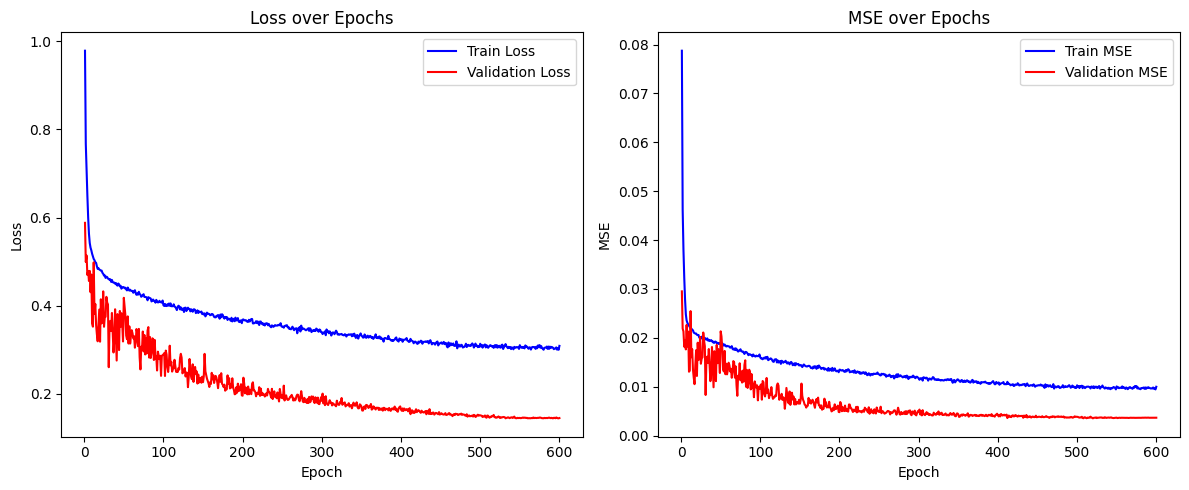

In [53]:
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

lr = 1e-4
epochs = 600
optimizer = optim.AdamW(model.parameters(), lr=lr)
# criterion = nn.MSELoss().to(device)
criterion = WingLoss().to(device)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3, 
    steps_per_epoch=len(train_loader),
    epochs=epochs,
    pct_start=0.02,
    final_div_factor=40000
)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',      
#     factor=0.5,      
#     patience=5,       
#     min_lr=1e-6,     
# )
# scheduler = CosineAnnealingWarmupRestarts(
#     optimizer,
#     first_cycle_steps=20,
#     cycle_mult=2,
#     max_lr=lr,
#     min_lr=lr/1000,
#     warmup_steps=6,
#     gamma=0.5
# )

best_val_loss = np.inf
best_val_mse = np.inf
epochs_no_improve = 0
patience = int(epochs/2)
#model_path = 'face_points.pth'
model_path = 'face_points_b_32_4.pth'

train_losses = []
train_mses = []
val_losses = []
val_mses = []

for epoch in tqdm(range(epochs), position=0, desc='Epoch'):
    model.train()
    train_loss = train_mse = train_seen = 0
    val_loss = val_mse = val_seen = 0

    with tqdm(train_loader, position=1, leave=False, desc='Train') as pbar:
        for i, data in enumerate(pbar):
            inputs, targets = data[0].to(device), data[1].to(device).float()
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item() * batch_size
            train_mse += (torch.sum((outputs-targets)**2)/outputs.shape[1]).item()
            train_seen += batch_size
            pbar.set_postfix(
                loss=f'{train_loss/train_seen:.4f}',
                rmse=f'{np.sqrt(train_mse/train_seen):.4f}',
                lr=f'{optimizer.param_groups[0]['lr']:.6f}'
            )

    model.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data[0].to(device), data[1].to(device).float()
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item() * batch_size
            val_mse += (torch.sum((outputs-targets)**2)/outputs.shape[1]).item()
            val_seen += batch_size
    
    train_loss /= train_seen
    train_mse /= train_seen
    val_loss /= val_seen
    val_mse /= val_seen
    # scheduler.step(val_loss)
    
    tqdm.write(f'Epoch {epoch+1} - train loss: {train_loss:.4f} - train rmse: {np.sqrt(train_mse):.4f} - val loss: {val_loss:.4f} - val rmse: {np.sqrt(val_mse):.4f}')
    train_losses.append(train_loss)
    train_mses.append(train_mse)
    val_losses.append(val_loss)
    val_mses.append(val_mse)

    if val_mse < best_val_mse:
        tqdm.write(f'Validation MSE improved ({best_val_mse:.4f} --> {val_mse:.4f}). Saving model...')
        torch.save(model.state_dict(), model_path)
        best_val_mse = val_mse
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        tqdm.write(f'Validation MSE did not improve. Counter: {epochs_no_improve}/{patience}')

    if epochs_no_improve >= patience:
        tqdm.write('Early stopping triggered.')
        break


if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, weights_only=False))
    print('Finished Training. Loaded best model.')
else:
    print('No improvement during training. Using final model.')

plot_metrics(train_losses, val_losses, train_mses, val_mses)


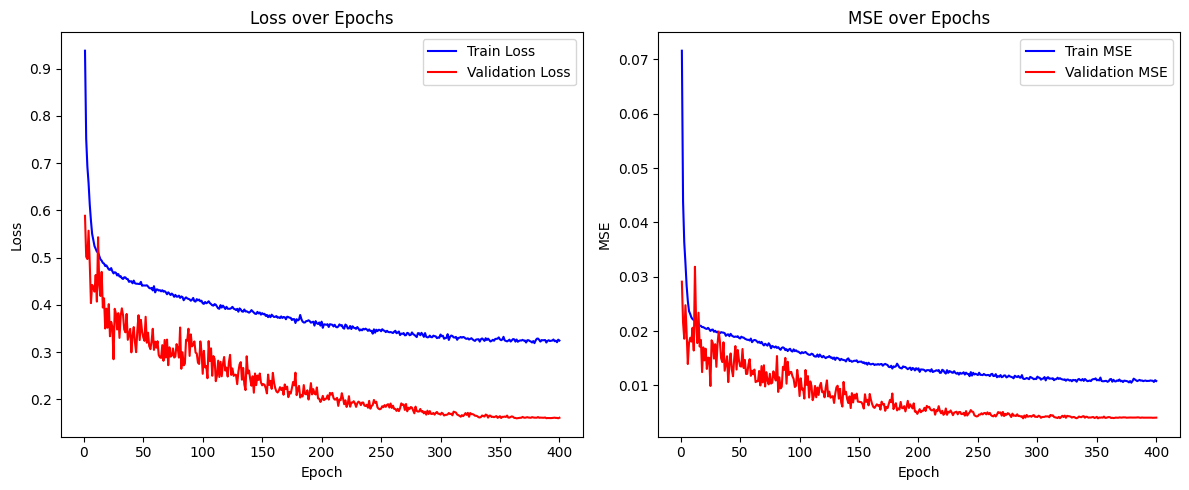

In [51]:
plot_metrics(train_losses, val_losses, train_mses, val_mses)

In [56]:
# model_path = './face_points.pth'      #pixel error 7.8px: generally better, but worse on rotations
# model_path = 'face_points_b_32.pth'   #pixel error 8.9px: better on rotations
# model_path = 'face_points_b_32_2.pth'   #pixel error 8.9px: better on rotations
# model_path = 'face_points_b_32_3.pth'   #pixel error 6.3px
model_path = 'face_points_b_32_4.pth'   #pixel error 5.9px

model.load_state_dict(torch.load(model_path, weights_only=False))

criterion = WingLoss().to(device)
val_loss = val_mse = val_seen = 0

model.eval()
with torch.no_grad():
    for data in val_loader:
        inputs, targets = data[0].to(device), data[1].to(device).float()
        outputs = model(inputs)
        val_loss += criterion(outputs, targets).item() * batch_size
        val_mse += (torch.sum((outputs-targets)**2)/outputs.shape[1]).item()
        val_seen += batch_size

val_loss /= val_seen
val_mse /= val_seen
print(f'Validation loss: {val_loss}, validation RMSE: {np.sqrt(val_mse)}')

Validation loss: 0.1441742007277514, validation RMSE: 0.05943501789030148


# Visualize Result

In [57]:
import matplotlib.pyplot as plt
import torch

def visualize_prediction(image_tensor, predicted_keypoints_tensor, target_size=100):
    """
    Визуализирует одно изображение с предсказанными моделью ключевыми точками.

    Args:
        image_tensor (torch.Tensor): Тензор изображения в формате [C, H, W].
        predicted_keypoints_tensor (torch.Tensor): Тензор предсказанных координат.
        target_size (int): Размер изображения, использованный при обучении.
    """
    image = image_tensor.cpu().permute(1, 2, 0)
    
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std + mean
    
    image = torch.clamp(image, 0, 1)

    keypoints = predicted_keypoints_tensor.detach().cpu().numpy()
    
    keypoints = keypoints.reshape(-1, 2) * target_size

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image)
    
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=40)
    
    # ax.set_title('Model Prediction')
    ax.axis('off')
    plt.show()



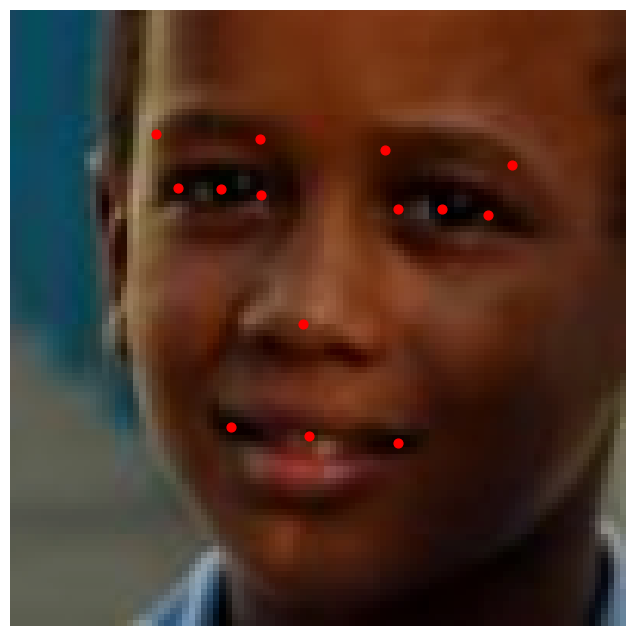

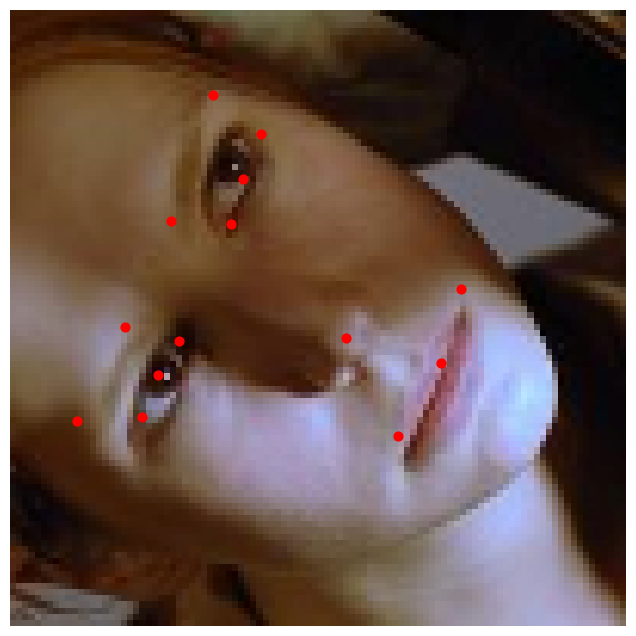

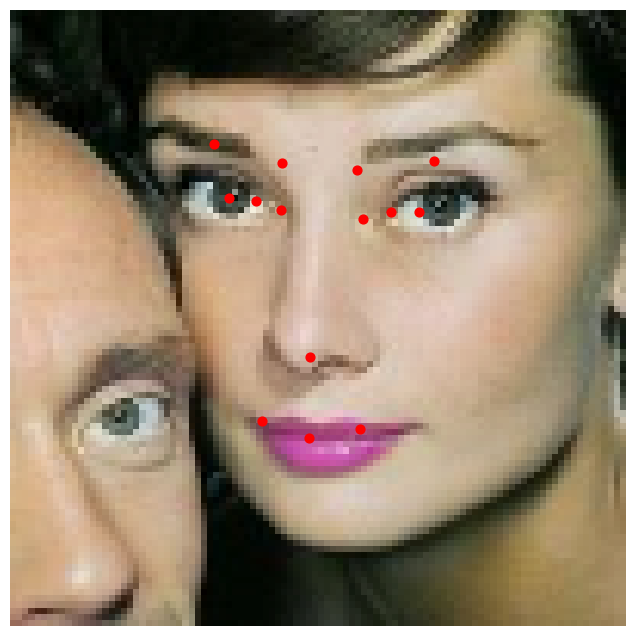

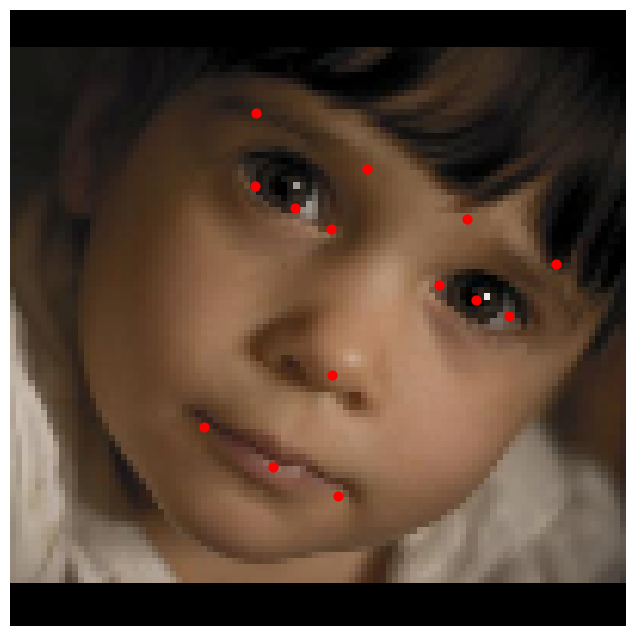

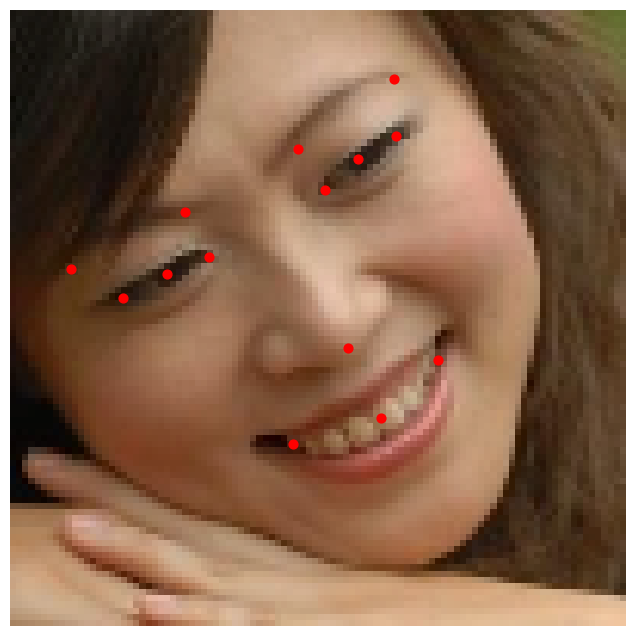

In [58]:
indices_to_visualize = [1, 2, 5, 20, 26] 

model.eval()

with torch.no_grad():
    
    for idx in indices_to_visualize:
        
        image_tensor = val_dataset[idx][0]
        input_tensor = image_tensor.unsqueeze(0).to(device)
        predicted_keypoints = model(input_tensor)
        predicted_keypoints = predicted_keypoints[0]
        visualize_prediction(image_tensor, predicted_keypoints)